In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
# Analysis
import time
import warnings
from datetime import date, timedelta

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import seaborn as sns
warnings.filterwarnings('ignore')

## Import Ngl with pyn_env active 
import Ngl


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values
    hybm = DS.hybm.values
    hyai = DS.hyai.values
    hybi = DS.hybi.values

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [4]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    DS['TKE'].attrs['units']   = 'm2/s2'
    DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

    DS['WindMagnitude'].attrs['units']   = 'm/s'
    DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','WP2RTP_CLUBB','THETAL','WindMagnitude'])

    for iVar in range(len(varSels)): 
        varUnits = DS[varSels[iVar]].units
        varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
    ## Resample to 30m means? 
    DS = DS.resample(time="30Min").mean()
        
    return DS

## Read in CAM data

In [5]:
## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                      'U10','CLDHGH','CLDLIQ','TMQ'])

In [6]:
archiveDir = '/glade/scratch/mdfowler/archive/'

# dateStrings = ['0609', '0923', '0715']
# yearStrings = ['2016', '2017', '2017']
# multiplVer  = ['V3',     'V4',   'V2']

dateStrings = ['0609', '0923', '0715',
               '0711', '0818', '0719']
yearStrings = ['2016', '2017', '2017',
               '2017', '2016', '2016']
caseEnd     = ['v2', 'v2', 'v2',
               '','','']

for iDay in range(len(dateStrings)):

    case_mult = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens'+yearStrings[iDay]+'_start'+dateStrings[iDay]+'_pert00/',
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_start'+dateStrings[iDay]+'_pert00/',
                 # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_mult5_start'+dateStrings[iDay]+'_pert00/', 
                 # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_mult10_start'+dateStrings[iDay]+'_pert00/',
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers250km_start'+dateStrings[iDay]+yearStrings[iDay]+caseEnd[iDay]+'/',    #LES-based multipliers
                ]

    caseMult_names = ['HMG','HTG*01','HTG*LESvals250']

    for iCase in range(len(case_mult)): 
        ## Get list of input files 
        listFiles_camh1 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h1*'))
        listFiles_camh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h0*'))
        listFiles_clmh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'lnd/hist/*clm2.h0*'))

        ## Should only be one file per glob above (ran for two days), so just open each DS here
        iFile = 0 
        with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as multDS: 
            multDS         = cesm_correct_time(multDS)
            multDS['time'] = multDS.indexes['time'].to_datetimeindex() 

        with xr.open_dataset(listFiles_clmh0[iFile], decode_times=True) as clm_multDS: 
            clm_multDS['time'] = multDS['time']



        ## Add variables as needed (some are on h0 file stream)
        for iVar in range(len(addVars)):
            varMult         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
            varMult['time'] = multDS['time']

            multDS = xr.merge([multDS, varMult])

        ## Select the second simulated day for analysis 
        iTimeStart_day2  = np.where( (multDS.time.values >= (multDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                     (multDS.time.values <= (multDS.time.values[0] + np.timedelta64(2,'D'))))[0]

        multDS      = multDS.isel(time=iTimeStart_day2)
        clm_multDS  = clm_multDS.isel(time=iTimeStart_day2)

        ## Give case attribute and combine 
        multDS     = multDS.assign_coords({"case":     caseMult_names[iCase]})
        clm_multDS = clm_multDS.assign_coords({"case": caseMult_names[iCase]})

        if iCase==0: 
            multDS_allCases     = multDS
            clm_multDS_allCases = clm_multDS
        else:
            multDS_allCases     = xr.concat([multDS_allCases,     multDS], "case")
            clm_multDS_allCases = xr.concat([clm_multDS_allCases, clm_multDS], "case")

        del multDS,clm_multDS

        print('Read in '+caseMult_names[iCase]+' case')
        
    if iDay==0:
        multDS_allDays     = multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})
        clm_multDS_allDays = clm_multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})
        
    else: 
        multDS_allDays     = xr.concat([multDS_allDays,     multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})], "strDate")
        clm_multDS_allDays = xr.concat([clm_multDS_allDays, clm_multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})], "strDate")
        
    print('Done with the day: %s %s' % (yearStrings[iDay], dateStrings[iDay]))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/glade/work/mdfowler/conda-envs/pyn_env/lib/python3.8/site-packages/xarray/backends/file_manager.py", line 199, in _acquire_with_cache_info
    file = self._cache[self._key]
  File "/glade/work/mdfowler/conda-envs/pyn_env/lib/python3.8/site-packages/xarray/backends/lru_cache.py", line 53, in __getitem__
    value = self._cache[key]
KeyError: [<class 'netCDF4._netCDF4.Dataset'>, ('/glade/scratch/mdfowler/archive/FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens2016_start0609_pert00/atm/hist/FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens2016_start0609_pert00.cam.h1.2016-06-09-18060.nc',), 'r', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('persist', False))]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/glade/work/mdfowler/conda-envs/pyn_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exe

TypeError: object of type 'NoneType' has no len()

In [ ]:
## Convert to local times...
# - - - - - - - - - - - - - - 
multDS_allDays_local    = multDS_allDays.copy(deep=True)
clm_multDS_allDays_local= clm_multDS_allDays.copy(deep=True)

# Compute local time 
localTimes = multDS_allDays['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
multDS_allDays_local    = multDS_allDays_local.assign_coords({"time": localTimes})
clm_multDS_allDays_local= clm_multDS_allDays_local.assign_coords({"time": localTimes})


In [ ]:
## Multiplier cases too 

for iDay in range(len(dateStrings)):
    for iCase in range(len(caseMult_names)):
        
        selTime = np.where((multDS_allDays_local['time.year']==int(yearStrings[iDay])) & 
                           (multDS_allDays_local['time.month']==int(dateStrings[iDay][0:2])) & 
                           (multDS_allDays_local['time.day']==int(dateStrings[iDay][2:4])+1) )[0]  ## Add a day - using second day of run 
        
        sel_mult = process_camData( multDS_allDays_local.sel(case=caseMult_names[iCase],
                                                           strDate=multDS_allDays_local.strDate.values[iDay]).isel(time=selTime) )

        if iCase==0: 
            mult_all = sel_mult
        else:
            mult_all = xr.concat([mult_all, sel_mult], "case")

        del sel_mult
        
    if iDay==0: 
        days_all = mult_all
    else:
        days_all = xr.concat([days_all, mult_all], "strDate")
    del mult_all
    print('Done with day %i of %i' % (iDay+1, len(dateStrings) ) )
    

In [ ]:
## Select one day per DS
days_all_20170716 = days_all.isel(time=np.where( (days_all['time.year']==2017) & (days_all['time.month']==7) & (days_all['time.day']==16))[0]).sel(strDate='2017_0715')
days_all_20160610 = days_all.isel(time=np.where( (days_all['time.year']==2016) & (days_all['time.month']==6) & (days_all['time.day']==10))[0]).sel(strDate='2016_0609')
days_all_20170924 = days_all.isel(time=np.where( (days_all['time.year']==2017) & (days_all['time.month']==9) & (days_all['time.day']==24))[0]).sel(strDate='2017_0923')

days_all_20170712 = days_all.isel(time=np.where( (days_all['time.year']==2017) & (days_all['time.month']==7) & (days_all['time.day']==12))[0]).sel(strDate='2017_0711')
days_all_20160819 = days_all.isel(time=np.where( (days_all['time.year']==2016) & (days_all['time.month']==8) & (days_all['time.day']==19))[0]).sel(strDate='2016_0818')
days_all_20160720 = days_all.isel(time=np.where( (days_all['time.year']==2016) & (days_all['time.month']==7) & (days_all['time.day']==20))[0]).sel(strDate='2016_0719')



## Read in LES data

**NOTE:** This directory has the extra days of higher order moments, but note that the resolution of the LES is now 250m, not 100m. We should certainly compare these... 

In [12]:
lesDir = '/glade/work/mdfowler/CLASP/LESdata_fromJason/allDays_250mRes/'
# lesDir = '/glade/scratch/mdfowler/CLASP_LESoutput/'

lesDateStrings = ['20160610', '20170716', '20170924',
                  '20170712', '20160819', '20160720']

for iDay in range(len(lesDateStrings)): 

    HTGds = xr.open_dataset(lesDir+'trimfr2_'+lesDateStrings[iDay]+'_00.nc', decode_times=False)
    HMGds = xr.open_dataset(lesDir+'trimfr2_'+lesDateStrings[iDay]+'_01.nc', decode_times=False)

    HTGds = HTGds.assign_coords({"case": 'HTG'})
    HMGds = HMGds.assign_coords({"case": 'HMG'})
    
    LES_allCases = xr.concat([HMGds, HTGds], "case")
    
    if lesDateStrings[iDay]=='20170712':
        LES_allCases_20170712 = LES_allCases
    elif lesDateStrings[iDay]=='20160819':
        LES_allCases_20160819 = LES_allCases
    elif lesDateStrings[iDay]=='20160720':
        LES_allCases_20160720 = LES_allCases
        
    elif lesDateStrings[iDay]=='20170716':
        LES_allCases_20170716 = LES_allCases
    elif lesDateStrings[iDay]=='20160610':
        LES_allCases_20160610 = LES_allCases
    elif lesDateStrings[iDay]=='20170924':
        LES_allCases_20170924 = LES_allCases
        
    else:
        print(' !! This day not ready to be defined !! ')
        
    print('Done with reading in ', lesDateStrings[iDay])
        
        

Done with reading in  20160610
Done with reading in  20170716
Done with reading in  20170924
Done with reading in  20170712
Done with reading in  20160819
Done with reading in  20160720


In [13]:
## Fix time arrays to be useful in the LES cases
startTime = datetime.datetime(2016,1,1, 0,0,0) - timedelta(hours = 5) # And convert to local time by -5hrs

## New days
times_20170712 = [] 
for iT in range(len(LES_allCases_20170712.time.values)): 
    timeStep       = startTime+timedelta(minutes = int(LES_allCases_20170712.time.values[iT]))
    times_20170712 = np.append(times_20170712, timeStep)
LES_allCases_20170712['datetime'] = (('time'), times_20170712)
LES_allCases_20170712             = LES_allCases_20170712.set_index(time='datetime')

times_20160819 = [] 
for iT in range(len(LES_allCases_20160819.time.values)): 
    timeStep       = startTime+timedelta(minutes = int(LES_allCases_20160819.time.values[iT]))
    times_20160819 = np.append(times_20160819, timeStep)
LES_allCases_20160819['datetime'] = (('time'), times_20160819)
LES_allCases_20160819             = LES_allCases_20160819.set_index(time='datetime')
    
    
times_20160720 = [] 
for iT in range(len(LES_allCases_20160720.time.values)): 
    timeStep       = startTime+timedelta(minutes = int(LES_allCases_20160720.time.values[iT]))
    times_20160720 = np.append(times_20160720, timeStep)
LES_allCases_20160720['datetime'] = (('time'), times_20160720)
LES_allCases_20160720             = LES_allCases_20160720.set_index(time='datetime')


## Previous days
times_20170716 = [] 
for iT in range(len(LES_allCases_20170716.time.values)): 
    timeStep       = startTime+timedelta(minutes = int(LES_allCases_20170716.time.values[iT]))
    times_20170716 = np.append(times_20170716, timeStep)
LES_allCases_20170716['datetime'] = (('time'), times_20170716)
LES_allCases_20170716             = LES_allCases_20170716.set_index(time='datetime')

times_20160610 = [] 
for iT in range(len(LES_allCases_20160610.time.values)): 
    timeStep       = startTime+timedelta(minutes = int(LES_allCases_20160610.time.values[iT]))
    times_20160610 = np.append(times_20160610, timeStep)
LES_allCases_20160610['datetime'] = (('time'), times_20160610)
LES_allCases_20160610             = LES_allCases_20160610.set_index(time='datetime')

times_20170924 = [] 
for iT in range(len(LES_allCases_20170924.time.values)): 
    timeStep       = startTime+timedelta(minutes = int(LES_allCases_20170924.time.values[iT]))
    times_20170924 = np.append(times_20170924, timeStep)
LES_allCases_20170924['datetime'] = (('time'), times_20170924)
LES_allCases_20170924             = LES_allCases_20170924.set_index(time='datetime')


**Also get some default data from the LES runs**

In [14]:
# lesDir = '/glade/work/mdfowler/CLASP/LESdata_fromJason/defaultOutput/chaney-web-00.egr.duke.edu/CLASP/LES/diags/'
lesDir = '/glade/scratch/mdfowler/CLASP_LESoutput/defaultOutput/chaney-web-00.egr.duke.edu/CLASP/LES/diags/'


for iDay in range(len(lesDateStrings)):

    HMGdir = lesDir+'doz_'+lesDateStrings[iDay]+'_01/'
    HTGdir = lesDir+'doz_'+lesDateStrings[iDay]+'_00/'

    listFilesHMG = np.sort(glob.glob(HMGdir+'diag_d01*'))
    listFilesHTG = np.sort(glob.glob(HTGdir+'diag_d01*'))

    for iFileHMG in range(len(listFilesHMG)): 
        dsHMG = xr.open_dataset(listFilesHMG[iFileHMG], decode_times=False)
        dsHMG = dsHMG.set_index(Time='XTIME').assign_coords({"case": 'HMG'})

        if iFileHMG==0:
            HMGds_lesDay = dsHMG 
        else: 
            HMGds_lesDay = xr.concat([HMGds_lesDay, dsHMG], dim='Time')

    for iFileHTG in range(len(listFilesHTG)): 
        dsHTG = xr.open_dataset(listFilesHTG[iFileHTG], decode_times=False)
        dsHTG = dsHTG.set_index(Time='XTIME').assign_coords({"case": 'HTG'})

        if iFileHTG==0:
            HTGds_lesDay = dsHTG 
        else: 
            HTGds_lesDay = xr.concat([HTGds_lesDay, dsHTG], dim='Time')


    LES_allCasesDefault = xr.concat([HMGds_lesDay, HTGds_lesDay], "case")
    
    if lesDateStrings[iDay]=='20170716':
        LES_allCasesDefault_20170716 = LES_allCasesDefault
    elif lesDateStrings[iDay]=='20160610':
        LES_allCasesDefault_20160610 = LES_allCasesDefault
    elif lesDateStrings[iDay]=='20170924':
        LES_allCasesDefault_20170924 = LES_allCasesDefault
        
    elif lesDateStrings[iDay]=='20170712':
        LES_allCasesDefault_20170712 = LES_allCasesDefault
    elif lesDateStrings[iDay]=='20160819':
        LES_allCasesDefault_20160819 = LES_allCasesDefault
    elif lesDateStrings[iDay]=='20160720':
        LES_allCasesDefault_20160720 = LES_allCasesDefault
        
    else:
        print(' !! This day not ready to be defined !! ')
        
    print('Done with reading in ', lesDateStrings[iDay])
        

Done with reading in  20160610
Done with reading in  20170716
Done with reading in  20170924
Done with reading in  20170712
Done with reading in  20160819
Done with reading in  20160720


In [15]:
## Fix time arrays for default data:

startTime_20160610   = datetime.datetime(2016,6,10, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST
times_20160610 = [] 
for iT in range(len(LES_allCasesDefault_20160610.Time.values)): 
    timeStep       = startTime_20160610+timedelta(minutes = int(LES_allCasesDefault_20160610.Time.values[iT]))
    times_20160610 = np.append(times_20160610, timeStep)
    
LES_allCasesDefault_20160610['datetime'] = (('Time'), times_20160610)
LES_allCasesDefault_20160610             = LES_allCasesDefault_20160610.set_index(Time='datetime')


startTime_20170716   = datetime.datetime(2017,7,16, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST
times_20170716 = [] 
for iT in range(len(LES_allCasesDefault_20170716.Time.values)): 
    timeStep       = startTime_20170716+timedelta(minutes = int(LES_allCasesDefault_20170716.Time.values[iT]))
    times_20170716 = np.append(times_20170716, timeStep)
    
LES_allCasesDefault_20170716['datetime'] = (('Time'), times_20170716)
LES_allCasesDefault_20170716             = LES_allCasesDefault_20170716.set_index(Time='datetime')



startTime_20170924   = datetime.datetime(2017,9,24, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST
times_20170924 = [] 
for iT in range(len(LES_allCasesDefault_20170924.Time.values)): 
    timeStep       = startTime_20170924+timedelta(minutes = int(LES_allCasesDefault_20170924.Time.values[iT]))
    times_20170924 = np.append(times_20170924, timeStep)
    
LES_allCasesDefault_20170924['datetime'] = (('Time'), times_20170924)
LES_allCasesDefault_20170924             = LES_allCasesDefault_20170924.set_index(Time='datetime')



startTime_20170712   = datetime.datetime(2017,7,12, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST
times_20170712 = [] 
for iT in range(len(LES_allCasesDefault_20170712.Time.values)): 
    timeStep       = startTime_20170712+timedelta(minutes = int(LES_allCasesDefault_20170712.Time.values[iT]))
    times_20170712 = np.append(times_20170712, timeStep)
    
LES_allCasesDefault_20170712['datetime'] = (('Time'), times_20170712)
LES_allCasesDefault_20170712             = LES_allCasesDefault_20170712.set_index(Time='datetime')


startTime_20160819   = datetime.datetime(2016,8,19, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST
times_20160819 = [] 
for iT in range(len(LES_allCasesDefault_20160819.Time.values)): 
    timeStep       = startTime_20160819+timedelta(minutes = int(LES_allCasesDefault_20160819.Time.values[iT]))
    times_20160819 = np.append(times_20160819, timeStep)
    
LES_allCasesDefault_20160819['datetime'] = (('Time'), times_20160819)
LES_allCasesDefault_20160819             = LES_allCasesDefault_20160819.set_index(Time='datetime')


startTime_20160720   = datetime.datetime(2016,7,20, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST
times_20160720 = [] 
for iT in range(len(LES_allCasesDefault_20160720.Time.values)): 
    timeStep       = startTime_20160720+timedelta(minutes = int(LES_allCasesDefault_20160720.Time.values[iT]))
    times_20160720 = np.append(times_20160720, timeStep)
    
LES_allCasesDefault_20160720['datetime'] = (('Time'), times_20160720)
LES_allCasesDefault_20160720             = LES_allCasesDefault_20160720.set_index(Time='datetime')


#### Also get info on strength of secondary circulation (Jason's file)

In [16]:
circulationTXT = '/glade/work/mdfowler/CLASP/LESdata_fromJason/circulations.txt'

circMetric = pd.read_csv(circulationTXT, sep=" ", header=None)
circMetric.columns = ['dateVal', 'metricVal']


In [17]:
print(' DateString      CirculationMetric')
print('-----------     -------------------')

for iDay in range(len(lesDateStrings)):
    iMatch = np.where(circMetric.dateVal==int(lesDateStrings[iDay]))[0]
    print(' %9i    %12.3f' %(circMetric.dateVal[iMatch], circMetric.metricVal[iMatch]) )
    
print()
print('25th percentile of all values: %8.3f' % np.nanpercentile(circMetric.metricVal.values, 25))
print('50th percentile of all values: %8.3f' % np.nanpercentile(circMetric.metricVal.values, 50))
print('75th percentile of all values: %8.3f' % np.nanpercentile(circMetric.metricVal.values, 75))
print('90th percentile of all values: %8.3f' % np.nanpercentile(circMetric.metricVal.values, 90))


 DateString      CirculationMetric
-----------     -------------------
  20160610           0.283
  20170716           2.427
  20170924           0.565
  20170712           0.681
  20160819           1.690
  20160720           0.816

25th percentile of all values:    0.136
50th percentile of all values:    0.399
75th percentile of all values:    0.817
90th percentile of all values:    1.637


## Get observational data too

In [6]:
forcingFile  = '/glade/work/mdfowler/CLASP/clasp-htg.bdate.nc'
forcDS       = xr.open_dataset(forcingFile, decode_times=True)

## Convert to local time
localTimes  = forcDS['time'].values - np.timedelta64(5,'h')
forcDS      = forcDS.assign_coords({"time": localTimes})

## Can we get a measure of vertically integrated moisture/temperature convergence? 
g = 9.8 
vertInt_T_adv_h = np.zeros([len(forcDS.time.values)])
vertInt_Q_adv_h = np.zeros([len(forcDS.time.values)])

for iP in range(len(forcDS.lev.values)-1):
    dP = (forcDS.lev.values[iP]-forcDS.lev.values[iP+1])*100.0 # Convert from hPa to Pa

    ## Adding a negative sign outside of the advective terms - 
    ##   These are the values of T and Q divergence, so their negative is *convergence* and easier to interpret
    vertInt_Tadv_levl = dP*(-forcDS.T_adv_h.values[:,iP,0,0]/3600.0) # Convert T_adv units from K/hr to K/s
    vertInt_Qadv_levl = dP*(-forcDS.q_adv_h.values[:,iP,0,0]/3600.0) # Convert Q_adv units from g/kg/hr to g/kg/s

    # Sum over all the levels 
    vertInt_T_adv_h = vertInt_T_adv_h + vertInt_Tadv_levl
    vertInt_Q_adv_h = vertInt_Q_adv_h + vertInt_Qadv_levl

vertInt_T_adv_h = vertInt_T_adv_h/g
vertInt_Q_adv_h = vertInt_Q_adv_h/g

forcDS['vertInt_T_adv_h'] = (('time'), vertInt_T_adv_h)
forcDS['vertInt_Q_adv_h'] = (('time'), vertInt_Q_adv_h)

## ------------------------------------------------------------------------------------

## Pick out the days of interest 
iDay_20160610   = np.where( (forcDS['time.year']==2016) & (forcDS['time.month']==6) & (forcDS['time.day']==10) )[0]
forcDS_20160610 = forcDS.isel(time=iDay_20160610)

iDay_20170716   = np.where( (forcDS['time.year']==2017) & (forcDS['time.month']==7) & (forcDS['time.day']==16) )[0]
forcDS_20170716 = forcDS.isel(time=iDay_20170716)

iDay_20170924   = np.where( (forcDS['time.year']==2017) & (forcDS['time.month']==9) & (forcDS['time.day']==24) )[0]
forcDS_20170924 = forcDS.isel(time=iDay_20170924)



iDay_20170712   = np.where( (forcDS['time.year']==2017) & (forcDS['time.month']==7) & (forcDS['time.day']==12) )[0]
forcDS_20170712 = forcDS.isel(time=iDay_20170712)

iDay_20160819   = np.where( (forcDS['time.year']==2016) & (forcDS['time.month']==8) & (forcDS['time.day']==19) )[0]
forcDS_20160819 = forcDS.isel(time=iDay_20160819)

iDay_20160720   = np.where( (forcDS['time.year']==2016) & (forcDS['time.month']==7) & (forcDS['time.day']==20) )[0]
forcDS_20160720 = forcDS.isel(time=iDay_20160720)



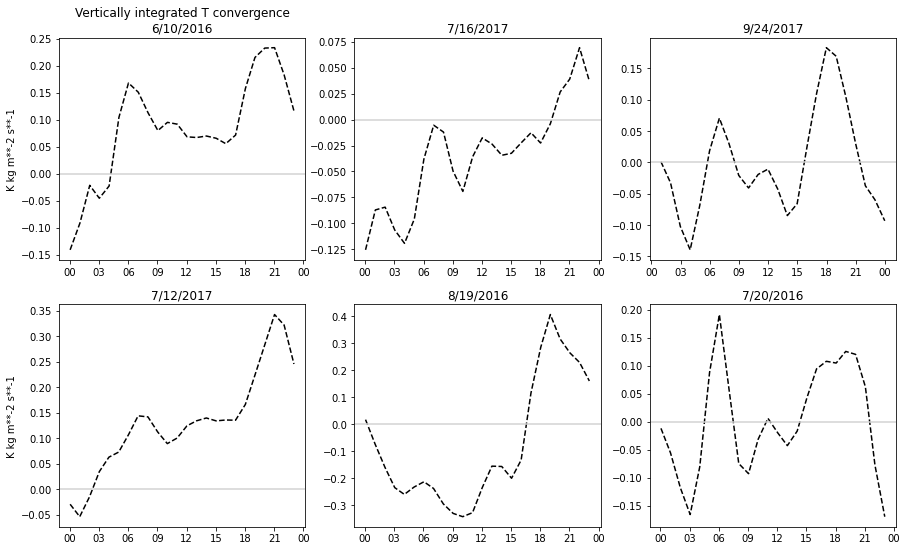

In [19]:
## Plot
fig,axs = plt.subplots(2,3, figsize=(15,9))
axs = axs.ravel()

titleString = 'Vertically integrated T convergence'
pltVar = 'vertInt_T_adv_h'
unitString = 'K kg m**-2 s**-1'
timeString = 'time'

axs[0].plot(forcDS_20160610.time.values, forcDS_20160610[pltVar].values, 'k--')
axs[0].set_ylabel(unitString)
axs[0].xaxis.set_major_formatter(DateFormatter("%H"))

axs[1].plot(forcDS_20170716.time.values, forcDS_20170716[pltVar].values, 'k--')
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))

axs[2].plot(forcDS_20170924.time.values, forcDS_20170924[pltVar].values, 'k--')
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[3].plot(forcDS_20170712.time.values, forcDS_20170712[pltVar].values, 'k--')
axs[3].set_ylabel(unitString)
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))

axs[4].plot(forcDS_20160819.time.values, forcDS_20160819[pltVar].values, 'k--')
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))

axs[5].plot(forcDS_20160720.time.values, forcDS_20160720[pltVar].values, 'k--')
axs[5].xaxis.set_major_formatter(DateFormatter("%H"))


## Set titles 
axs[0].set_title(titleString+'\n'+
              str(forcDS_20160610[timeString+'.month'].values[0])+'/'+
              str(forcDS_20160610[timeString+'.day'].values[0])+'/'+
              str(forcDS_20160610[timeString+'.year'].values[0])  )

axs[1].set_title('\n'+
              str(forcDS_20170716[timeString+'.month'].values[0])+'/'+
              str(forcDS_20170716[timeString+'.day'].values[0])+'/'+
              str(forcDS_20170716[timeString+'.year'].values[0]) )

axs[2].set_title('\n'+
              str(forcDS_20170924[timeString+'.month'].values[0])+'/'+
              str(forcDS_20170924[timeString+'.day'].values[0])+'/'+
              str(forcDS_20170924[timeString+'.year'].values[0]) )

axs[3].set_title('\n'+
              str(forcDS_20170712[timeString+'.month'].values[0])+'/'+
              str(forcDS_20170712[timeString+'.day'].values[0])+'/'+
              str(forcDS_20170712[timeString+'.year'].values[0]) )

axs[4].set_title('\n'+
              str(forcDS_20160819[timeString+'.month'].values[0])+'/'+
              str(forcDS_20160819[timeString+'.day'].values[0])+'/'+
              str(forcDS_20160819[timeString+'.year'].values[0]) ) 

axs[5].set_title('\n'+
              str(forcDS_20160720[timeString+'.month'].values[0])+'/'+
              str(forcDS_20160720[timeString+'.day'].values[0])+'/'+
              str(forcDS_20160720[timeString+'.year'].values[0]) )

axs[0].axhline(0,color='lightgrey')
axs[1].axhline(0,color='lightgrey')
axs[2].axhline(0,color='lightgrey')
axs[3].axhline(0,color='lightgrey')
axs[4].axhline(0,color='lightgrey')
axs[5].axhline(0,color='lightgrey')


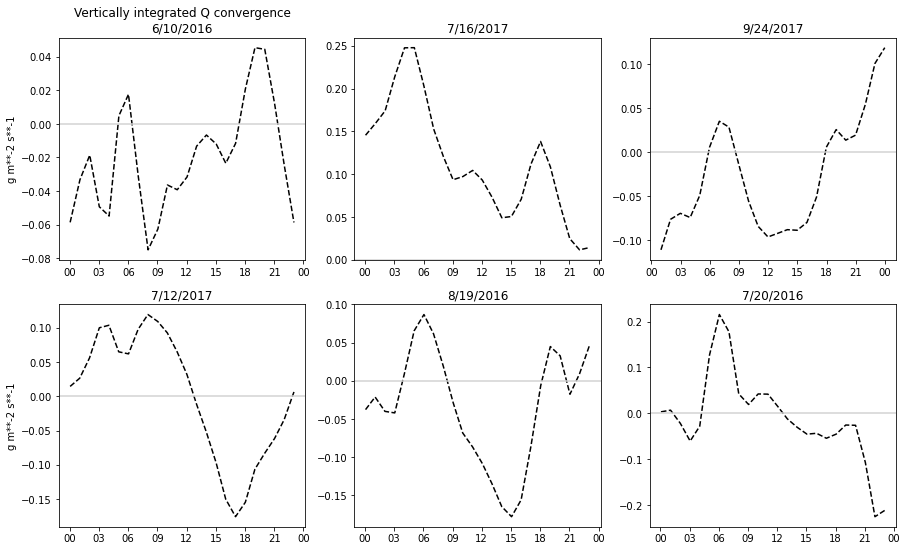

In [66]:
## Plot
fig,axs = plt.subplots(2,3, figsize=(15,9))
axs = axs.ravel()

titleString = 'Vertically integrated Q convergence'
pltVar = 'vertInt_Q_adv_h'
unitString = 'g m**-2 s**-1'
timeString = 'time'

axs[0].plot(forcDS_20160610.time.values, forcDS_20160610[pltVar].values, 'k--')
axs[0].set_ylabel(unitString)
axs[0].xaxis.set_major_formatter(DateFormatter("%H"))

axs[1].plot(forcDS_20170716.time.values, forcDS_20170716[pltVar].values, 'k--')
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))

axs[2].plot(forcDS_20170924.time.values, forcDS_20170924[pltVar].values, 'k--')
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[3].plot(forcDS_20170712.time.values, forcDS_20170712[pltVar].values, 'k--')
axs[3].set_ylabel(unitString)
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))

axs[4].plot(forcDS_20160819.time.values, forcDS_20160819[pltVar].values, 'k--')
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))

axs[5].plot(forcDS_20160720.time.values, forcDS_20160720[pltVar].values, 'k--')
axs[5].xaxis.set_major_formatter(DateFormatter("%H"))


## Set titles 
axs[0].set_title(titleString+'\n'+
              str(forcDS_20160610[timeString+'.month'].values[0])+'/'+
              str(forcDS_20160610[timeString+'.day'].values[0])+'/'+
              str(forcDS_20160610[timeString+'.year'].values[0])  )

axs[1].set_title('\n'+
              str(forcDS_20170716[timeString+'.month'].values[0])+'/'+
              str(forcDS_20170716[timeString+'.day'].values[0])+'/'+
              str(forcDS_20170716[timeString+'.year'].values[0]) )

axs[2].set_title('\n'+
              str(forcDS_20170924[timeString+'.month'].values[0])+'/'+
              str(forcDS_20170924[timeString+'.day'].values[0])+'/'+
              str(forcDS_20170924[timeString+'.year'].values[0]) )

axs[3].set_title('\n'+
              str(forcDS_20170712[timeString+'.month'].values[0])+'/'+
              str(forcDS_20170712[timeString+'.day'].values[0])+'/'+
              str(forcDS_20170712[timeString+'.year'].values[0]) )

axs[4].set_title('\n'+
              str(forcDS_20160819[timeString+'.month'].values[0])+'/'+
              str(forcDS_20160819[timeString+'.day'].values[0])+'/'+
              str(forcDS_20160819[timeString+'.year'].values[0]) ) 

axs[5].set_title('\n'+
              str(forcDS_20160720[timeString+'.month'].values[0])+'/'+
              str(forcDS_20160720[timeString+'.day'].values[0])+'/'+
              str(forcDS_20160720[timeString+'.year'].values[0]) )

axs[0].axhline(0,color='lightgrey')
axs[1].axhline(0,color='lightgrey')
axs[2].axhline(0,color='lightgrey')
axs[3].axhline(0,color='lightgrey')
axs[4].axhline(0,color='lightgrey')
axs[5].axhline(0,color='lightgrey')


## Begin comparing simulations

In [44]:
def printInfo(LESds, LESvar, LESunitsAdjust, 
              CAMds, CAMvar, dateString):
    
    print('-----------\n',str(CAMds['time.month'].values[0])+'/'+str(CAMds['time.day'].values[0])+'/'+str(CAMds['time.year'].values[0]),'\n-----------')
    print(LESvar)
    print('  Daily max (LES):    %8.3f' % (np.nanmax(LESds[LESvar].sel(case='HTG').values[:,0])*LESunitsAdjust ))
    print(CAMvar)
    print('  Daily max (SCAM):   %8.3f' % (np.nanmax(CAMds[CAMvar].sel(case='HTG*01').isel(ilev=-1).values-CAMds[CAMvar].sel(case='HMG').isel(ilev=-1).values)) )
    print('Suggested multiplier: %8.2f' % ((np.nanmax(LESds[LESvar].sel(case='HTG').values[:,0])*LESunitsAdjust )/(np.nanmax(CAMds[CAMvar].sel(case='HTG*01').isel(ilev=-1).values-CAMds[CAMvar].sel(case='HMG').isel(ilev=-1).values))) )
    
    return

In [18]:

printInfo(LES_allCases_20160610, 'thl2', 1.0, 
          days_all_20160610, 'THLP2_CLUBB', '20160610')

printInfo(LES_allCases_20170716, 'thl2', 1.0, 
          days_all_20170716, 'THLP2_CLUBB', '20170716')

printInfo(LES_allCases_20170924, 'thl2', 1.0, 
          days_all_20170924, 'THLP2_CLUBB', '20170924')



printInfo(LES_allCases_20170712, 'thl2', 1.0, 
          days_all_20170712, 'THLP2_CLUBB', '20170712')

printInfo(LES_allCases_20160819, 'thl2', 1.0, 
          days_all_20160819, 'THLP2_CLUBB', '20160819')

printInfo(LES_allCases_20160720, 'thl2', 1.0, 
          days_all_20160720, 'THLP2_CLUBB', '20160720')



-----------
 6/10/2016 
-----------
thl2
  Daily max (LES):       0.541
THLP2_CLUBB
  Daily max (SCAM):      0.109
Suggested multiplier:     4.97
-----------
 7/16/2017 
-----------
thl2
  Daily max (LES):       1.681
THLP2_CLUBB
  Daily max (SCAM):      0.109
Suggested multiplier:    15.39
-----------
 9/24/2017 
-----------
thl2
  Daily max (LES):       0.690
THLP2_CLUBB
  Daily max (SCAM):      0.025
Suggested multiplier:    27.99
-----------
 7/12/2017 
-----------
thl2
  Daily max (LES):       0.138
THLP2_CLUBB
  Daily max (SCAM):      0.249
Suggested multiplier:     0.55
-----------
 8/19/2016 
-----------
thl2
  Daily max (LES):      15.792
THLP2_CLUBB
  Daily max (SCAM):      0.036
Suggested multiplier:   433.58
-----------
 7/20/2016 
-----------
thl2
  Daily max (LES):       0.362
THLP2_CLUBB
  Daily max (SCAM):      0.143
Suggested multiplier:     2.53


In [40]:
0.036*433


15.588

In [19]:

printInfo(LES_allCases_20160610, 'qv2', 1e6, 
          days_all_20160610, 'RTP2_CLUBB', '20160610')

printInfo(LES_allCases_20170716, 'qv2', 1e6, 
          days_all_20170716, 'RTP2_CLUBB', '20170716')

printInfo(LES_allCases_20170924, 'qv2', 1e6, 
          days_all_20170924, 'RTP2_CLUBB', '20170924')



printInfo(LES_allCases_20170712, 'qv2', 1e6, 
          days_all_20170712, 'RTP2_CLUBB', '20170712')

printInfo(LES_allCases_20160819, 'qv2', 1e6, 
          days_all_20160819, 'RTP2_CLUBB', '20160819')

printInfo(LES_allCases_20160720, 'qv2', 1e6, 
          days_all_20160720, 'RTP2_CLUBB', '20160720')



-----------
 6/10/2016 
-----------
qv2
  Daily max (LES):       0.175
RTP2_CLUBB
  Daily max (SCAM):      0.210
Suggested multiplier:     0.83
-----------
 7/16/2017 
-----------
qv2
  Daily max (LES):       3.764
RTP2_CLUBB
  Daily max (SCAM):      0.494
Suggested multiplier:     7.62
-----------
 9/24/2017 
-----------
qv2
  Daily max (LES):       0.117
RTP2_CLUBB
  Daily max (SCAM):      0.086
Suggested multiplier:     1.36
-----------
 7/12/2017 
-----------
qv2
  Daily max (LES):       0.316
RTP2_CLUBB
  Daily max (SCAM):      0.415
Suggested multiplier:     0.76
-----------
 8/19/2016 
-----------
qv2
  Daily max (LES):       5.003
RTP2_CLUBB
  Daily max (SCAM):      0.041
Suggested multiplier:   121.70
-----------
 7/20/2016 
-----------
qv2
  Daily max (LES):       0.191
RTP2_CLUBB
  Daily max (SCAM):      0.211
Suggested multiplier:     0.90


In [22]:
strLabels = lesDateStrings

circMetric = np.asarray([0.283,  2.427,  0.565,  0.681,  1.690,  0.816])
thlp2_mult = np.asarray([ 4.97,  15.39,  27.99,  0.55,  433.58,   2.53])
rtp2_mult  = np.asarray([ 0.83,   7.62,   1.36,  0.76,  121.70,   0.90])


In [23]:
lesDateStrings

['20160610', '20170716', '20170924', '20170712', '20160819', '20160720']

Text(0, 0.5, 'Multiplier magnitude')

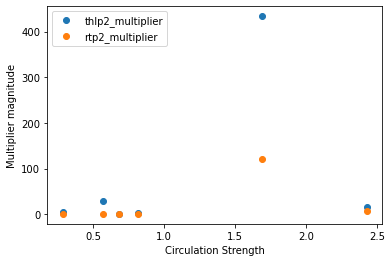

In [26]:
plt.plot(circMetric, thlp2_mult,'o')
plt.plot(circMetric, rtp2_mult,'o')
plt.legend(['thlp2_multiplier','rtp2_multiplier'], loc='upper left')
plt.xlabel('Circulation Strength')
plt.ylabel('Multiplier magnitude')

In [34]:
LES_allCases_20160610.thl2.sel(case='HMG').isel(k=0)

<xarray.DataArray 'thl2' (time: 91)>
array([0.00000000e+00, 2.51128280e-04, 3.84823761e-05, 9.40216341e-05,
       2.71539786e-04, 7.55026238e-04, 1.56871439e-03, 2.76360987e-03,
       4.19930136e-03, 5.81007637e-03, 8.79869238e-03, 1.37349870e-02,
       1.89250298e-02, 2.19728369e-02, 2.38683149e-02, 2.68078446e-02,
       3.06803193e-02, 3.49468403e-02, 3.94117162e-02, 4.39900830e-02,
       4.84587289e-02, 5.32950163e-02, 5.75924702e-02, 6.09738827e-02,
       6.47618026e-02, 6.78247884e-02, 6.92958310e-02, 7.17189237e-02,
       7.42449537e-02, 7.67460689e-02, 7.94378147e-02, 8.31226557e-02,
       8.88552889e-02, 9.43293422e-02, 1.04776956e-01, 1.12331308e-01,
       1.29100412e-01, 1.39736637e-01, 1.46635920e-01, 1.42797500e-01,
       1.63909048e-01, 1.72970846e-01, 1.95425600e-01, 2.13512465e-01,
       2.10893512e-01, 1.93790123e-01, 2.14253381e-01, 2.35162616e-01,
       2.33899757e-01, 2.11408496e-01, 2.17758149e-01, 2.35290498e-01,
       2.42810845e-01, 2.75116920e-01, 2.66058266e-01, 2.31474996e-01,
       2.32232064e-01, 2.44387433e-01, 2.52426326e-01, 2.18620420e-01,
       1.82799429e-01, 1.78904936e-01, 1.62748203e-01, 1.61113411e-01,
       1.28836229e-01, 9.91349891e-02, 7.39030465e-02, 5.39208949e-02,
       4.33960631e-02, 3.15127671e-02, 2.32960917e-02, 1.80856623e-02,
       1.45880478e-02, 1.20806303e-02, 1.02889482e-02, 8.96611996e-03,
       7.98744801e-03, 7.26747978e-03, 6.75706333e-03, 6.39868248e-03,
       6.02025259e-03, 5.57384500e-03, 5.15320012e-03, 4.78606671e-03,
       4.44020005e-03, 4.10455139e-03, 3.72387841e-03, 3.34903831e-03,
       3.05319135e-03, 2.81511201e-03, 2.60286266e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-06-10T07:00:00 ... 2016-06-10T22:00:00
    k        int32 0
    case     <U3 'HMG'
Attributes:
    units:    K2

In [35]:
LES_allCases_20160610.thl2.sel(case='HMG').values[:,0]


array([0.00000000e+00, 2.51128280e-04, 3.84823761e-05, 9.40216341e-05,
       2.71539786e-04, 7.55026238e-04, 1.56871439e-03, 2.76360987e-03,
       4.19930136e-03, 5.81007637e-03, 8.79869238e-03, 1.37349870e-02,
       1.89250298e-02, 2.19728369e-02, 2.38683149e-02, 2.68078446e-02,
       3.06803193e-02, 3.49468403e-02, 3.94117162e-02, 4.39900830e-02,
       4.84587289e-02, 5.32950163e-02, 5.75924702e-02, 6.09738827e-02,
       6.47618026e-02, 6.78247884e-02, 6.92958310e-02, 7.17189237e-02,
       7.42449537e-02, 7.67460689e-02, 7.94378147e-02, 8.31226557e-02,
       8.88552889e-02, 9.43293422e-02, 1.04776956e-01, 1.12331308e-01,
       1.29100412e-01, 1.39736637e-01, 1.46635920e-01, 1.42797500e-01,
       1.63909048e-01, 1.72970846e-01, 1.95425600e-01, 2.13512465e-01,
       2.10893512e-01, 1.93790123e-01, 2.14253381e-01, 2.35162616e-01,
       2.33899757e-01, 2.11408496e-01, 2.17758149e-01, 2.35290498e-01,
       2.42810845e-01, 2.75116920e-01, 2.66058266e-01, 2.31474996e-01,
      

In [30]:
def plotDiurnalCycle_LES(pltVar,  ilevSel, DSselection, takeMean=False): 
    
    if DSselection=='default':
        HMGles_20160610 = LES_allCasesDefault_20160610[pltVar].sel(case='HMG').values
        HMGles_20170716 = LES_allCasesDefault_20170716[pltVar].sel(case='HMG').values
        HMGles_20170924 = LES_allCasesDefault_20170924[pltVar].sel(case='HMG').values
        HMGles_20170712 = LES_allCasesDefault_20170712[pltVar].sel(case='HMG').values
        HMGles_20160819 = LES_allCasesDefault_20160819[pltVar].sel(case='HMG').values
        HMGles_20160720 = LES_allCasesDefault_20160720[pltVar].sel(case='HMG').values
        
        HTGles_20160610 = LES_allCasesDefault_20160610[pltVar].sel(case='HTG').values
        HTGles_20170716 = LES_allCasesDefault_20170716[pltVar].sel(case='HTG').values
        HTGles_20170924 = LES_allCasesDefault_20170924[pltVar].sel(case='HTG').values
        HTGles_20170712 = LES_allCasesDefault_20170712[pltVar].sel(case='HTG').values
        HTGles_20160819 = LES_allCasesDefault_20160819[pltVar].sel(case='HTG').values
        HTGles_20160720 = LES_allCasesDefault_20160720[pltVar].sel(case='HTG').values
        
        times20160610   = LES_allCasesDefault_20160610.Time
        times20170716   = LES_allCasesDefault_20170716.Time
        times20170924   = LES_allCasesDefault_20170924.Time
        times20170712   = LES_allCasesDefault_20170712.Time
        times20160819   = LES_allCasesDefault_20160819.Time
        times20160720   = LES_allCasesDefault_20160720.Time
        
        timeString  = 'Time'
        unitString  = LES_allCasesDefault[pltVar].units
        titleString = LES_allCasesDefault[pltVar].description
        
        if takeMean==True:
            HMGles_20160610 = np.nanmean(np.nanmean(HMGles_20160610,axis=1), axis=1)
            HMGles_20170716 = np.nanmean(np.nanmean(HMGles_20170716,axis=1), axis=1)
            HMGles_20170924 = np.nanmean(np.nanmean(HMGles_20170924,axis=1), axis=1)
            HMGles_20170712 = np.nanmean(np.nanmean(HMGles_20170712,axis=1), axis=1)
            HMGles_20160819 = np.nanmean(np.nanmean(HMGles_20160819,axis=1), axis=1)
            HMGles_20160720 = np.nanmean(np.nanmean(HMGles_20160720,axis=1), axis=1)
            
            HTGles_20160610 = np.nanmean(np.nanmean(HTGles_20160610,axis=1), axis=1)
            HTGles_20170716 = np.nanmean(np.nanmean(HTGles_20170716,axis=1), axis=1)
            HTGles_20170924 = np.nanmean(np.nanmean(HTGles_20170924,axis=1), axis=1)
            HTGles_20170712 = np.nanmean(np.nanmean(HTGles_20170712,axis=1), axis=1)
            HTGles_20160819 = np.nanmean(np.nanmean(HTGles_20160819,axis=1), axis=1)
            HTGles_20160720 = np.nanmean(np.nanmean(HTGles_20160720,axis=1), axis=1)
        
    elif DSselection=='moments': 
        if ilevSel==None:
            HMGles_20160610 = LES_allCases_20160610[pltVar].sel(case='HMG').values
            HMGles_20170716 = LES_allCases_20170716[pltVar].sel(case='HMG').values
            HMGles_20170924 = LES_allCases_20170924[pltVar].sel(case='HMG').values
            HMGles_20170712 = LES_allCases_20170712[pltVar].sel(case='HMG').values
            HMGles_20160819 = LES_allCases_20160819[pltVar].sel(case='HMG').values
            HMGles_20160720 = LES_allCases_20160720[pltVar].sel(case='HMG').values

            HTGles_20160610 = LES_allCases_20160610[pltVar].sel(case='HTG').values
            HTGles_20170716 = LES_allCases_20170716[pltVar].sel(case='HTG').values
            HTGles_20170924 = LES_allCases_20170924[pltVar].sel(case='HTG').values
            HTGles_20170712 = LES_allCases_20170712[pltVar].sel(case='HTG').values
            HTGles_20160819 = LES_allCases_20160819[pltVar].sel(case='HTG').values
            HTGles_20160720 = LES_allCases_20160720[pltVar].sel(case='HTG').values
        else:
            HMGles_20160610 = LES_allCases_20160610.isel(k=ilevSel)[pltVar].sel(case='HMG').values
            HMGles_20170716 = LES_allCases_20170716.isel(k=ilevSel)[pltVar].sel(case='HMG').values
            HMGles_20170924 = LES_allCases_20170924.isel(k=ilevSel)[pltVar].sel(case='HMG').values
            HMGles_20170712 = LES_allCases_20170712.isel(k=ilevSel)[pltVar].sel(case='HMG').values
            HMGles_20160819 = LES_allCases_20160819.isel(k=ilevSel)[pltVar].sel(case='HMG').values
            HMGles_20160720 = LES_allCases_20160720.isel(k=ilevSel)[pltVar].sel(case='HMG').values

            HTGles_20160610 = LES_allCases_20160610.isel(k=ilevSel)[pltVar].sel(case='HTG').values
            HTGles_20170716 = LES_allCases_20170716.isel(k=ilevSel)[pltVar].sel(case='HTG').values
            HTGles_20170924 = LES_allCases_20170924.isel(k=ilevSel)[pltVar].sel(case='HTG').values
            HTGles_20170712 = LES_allCases_20170712.isel(k=ilevSel)[pltVar].sel(case='HTG').values
            HTGles_20160819 = LES_allCases_20160819.isel(k=ilevSel)[pltVar].sel(case='HTG').values
            HTGles_20160720 = LES_allCases_20160720.isel(k=ilevSel)[pltVar].sel(case='HTG').values
            
        
        times20160610   = LES_allCases_20160610.time
        times20170716   = LES_allCases_20170716.time
        times20170924   = LES_allCases_20170924.time
        times20170712   = LES_allCases_20170712.time
        times20160819   = LES_allCases_20160819.time
        times20160720   = LES_allCases_20160720.time
        
        timeString      = 'time'
        unitString      = LES_allCases[pltVar].units
        titleString     = pltVar+' at level = '+str(ilevSel)
    else: 
        print('Valid selections for DSselection are (strings) [default, moments]')
        
    
    ## Plot
    fig,axs = plt.subplots(2,3, figsize=(15,9))
    axs = axs.ravel()
    
    axs[0].plot(times20160610, HMGles_20160610, color='indigo', label='HMG')
    axs[0].plot(times20160610, HTGles_20160610, color='mediumorchid', label='HTG')
    axs[0].legend()
    axs[0].set_ylabel(unitString)
    axs[0].xaxis.set_major_formatter(DateFormatter("%H"))

    axs[1].plot(times20170716, HMGles_20170716, color='indigo', label='HMG')
    axs[1].plot(times20170716, HTGles_20170716, color='mediumorchid', label='HTG')
    # axs[1].legend()
    axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
    
    axs[2].plot(times20170924, HMGles_20170924, color='indigo', label='HMG')
    axs[2].plot(times20170924, HTGles_20170924, color='mediumorchid', label='HTG')
    # axs[2].legend()
    axs[2].xaxis.set_major_formatter(DateFormatter("%H"))
    
    axs[3].plot(times20170712, HMGles_20170712, color='indigo', label='HMG')
    axs[3].plot(times20170712, HTGles_20170712, color='mediumorchid', label='HTG')
    # axs[3].legend()
    axs[3].set_ylabel(unitString)
    axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
    
    axs[4].plot(times20160819, HMGles_20160819, color='indigo', label='HMG')
    axs[4].plot(times20160819, HTGles_20160819, color='mediumorchid', label='HTG')
    # axs[4].legend()
    axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
    
    axs[5].plot(times20160720, HMGles_20160720, color='indigo', label='HMG')
    axs[5].plot(times20160720, HTGles_20160720, color='mediumorchid', label='HTG')
    # axs[5].legend()
    axs[5].xaxis.set_major_formatter(DateFormatter("%H"))
    
    
    ## Set titles 
    axs[0].set_title(titleString+'\n'+
                  str(times20160610[timeString+'.month'].values[0])+'/'+
                  str(times20160610[timeString+'.day'].values[0])+'/'+
                  str(times20160610[timeString+'.year'].values[0])  )

    axs[1].set_title('\n'+
                  str(times20170716[timeString+'.month'].values[0])+'/'+
                  str(times20170716[timeString+'.day'].values[0])+'/'+
                  str(times20170716[timeString+'.year'].values[0]) )

    axs[2].set_title('\n'+
                  str(times20170924[timeString+'.month'].values[0])+'/'+
                  str(times20170924[timeString+'.day'].values[0])+'/'+
                  str(times20170924[timeString+'.year'].values[0]) )
    
    axs[3].set_title('\n'+
                  str(times20170712[timeString+'.month'].values[0])+'/'+
                  str(times20170712[timeString+'.day'].values[0])+'/'+
                  str(times20170712[timeString+'.year'].values[0]) )

    axs[4].set_title('\n'+
                  str(times20160819[timeString+'.month'].values[0])+'/'+
                  str(times20160819[timeString+'.day'].values[0])+'/'+
                  str(times20160819[timeString+'.year'].values[0]) ) 

    axs[5].set_title('\n'+
                  str(times20160720[timeString+'.month'].values[0])+'/'+
                  str(times20160720[timeString+'.day'].values[0])+'/'+
                  str(times20160720[timeString+'.year'].values[0]) )
    
    
    return axs

array([<AxesSubplot:title={'center':'rain at surface\n6/10/2016'}, ylabel='mm s-1'>,
       <AxesSubplot:title={'center':'\n7/16/2017'}>,
       <AxesSubplot:title={'center':'\n9/24/2017'}>,
       <AxesSubplot:title={'center':'\n7/12/2017'}, ylabel='mm s-1'>,
       <AxesSubplot:title={'center':'\n8/19/2016'}>,
       <AxesSubplot:title={'center':'\n7/20/2016'}>], dtype=object)

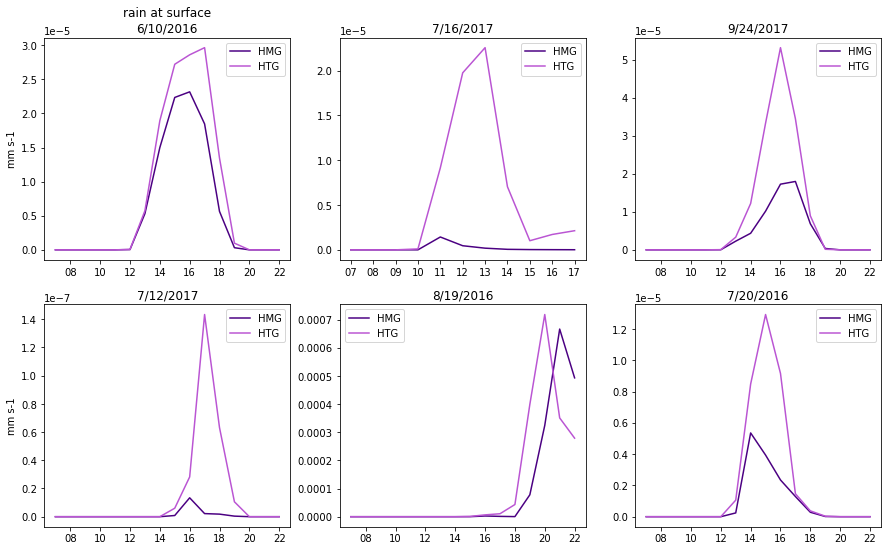

In [34]:
# plotDiurnalCycle_LES('AVT_LWP', None, 'default', False)
plotDiurnalCycle_LES('AVS_RAIN', None, 'default', True)

# plotDiurnalCycle_LES('thl2', 0, 'moments', False)


(17002.291666666668, 17002.916666666668)

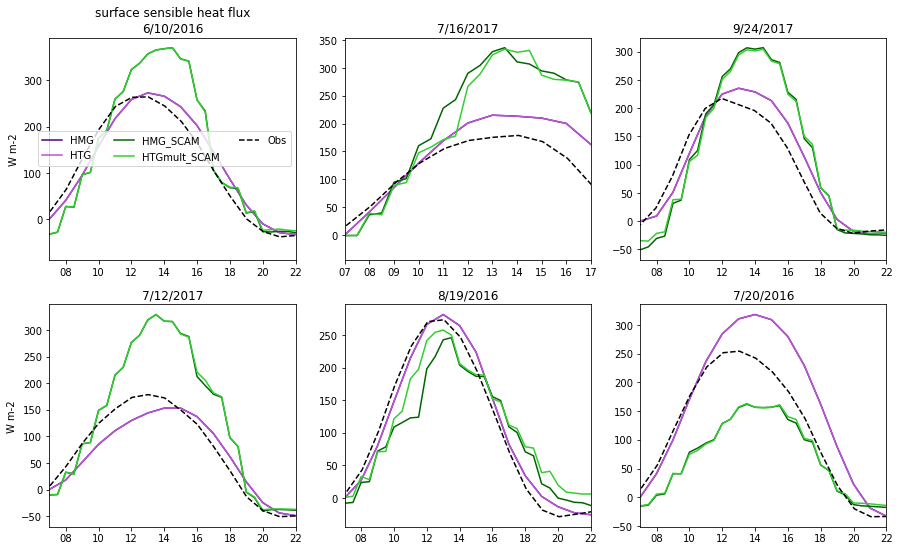

In [31]:
# axs = plotDiurnalCycle_LES('AVS_RAIN', None, 'default', True)
# ## Add SCAM output to the same plots 
# scamVar  = 'PRECT'
# scamMult = 1000.0

axs = plotDiurnalCycle_LES('AVS_SH', None, 'default', True)
## Add SCAM output to the same plots 
scamVar  = 'SHFLX'
scamMult = 1.0
obsVar   = 'SH'

axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )

axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )

axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )

axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )

axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )


axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )



## Add observations too (LASSO VARANAL)
axs[0].plot(forcDS_20160610.time.values, np.squeeze(forcDS_20160610[obsVar].values),'k--', label='Obs' )
axs[0].legend(ncol=3)

axs[1].plot(forcDS_20170716.time.values, np.squeeze(forcDS_20170716[obsVar].values), 'k--', label='Obs')
# axs[1].legend(ncol=2)

axs[2].plot(forcDS_20170924.time.values, np.squeeze(forcDS_20170924[obsVar].values), 'k--', label='Obs')
# axs[2].legend(ncol=2)

axs[3].plot(forcDS_20170712.time.values, np.squeeze(forcDS_20170712[obsVar].values), 'k--', label='Obs')
# axs[3].legend(ncol=2)

axs[4].plot(forcDS_20160819.time.values, np.squeeze(forcDS_20160819[obsVar].values), 'k--', label='Obs')
# axs[4].legend(ncol=2)

axs[5].plot(forcDS_20160720.time.values, np.squeeze(forcDS_20160720[obsVar].values), 'k--', label='Obs')
# axs[5].legend(ncol=2)


axs[0].set_xlim([LES_allCasesDefault_20160610['Time'].values[0], LES_allCasesDefault_20160610['Time'].values[-1]])
axs[1].set_xlim([LES_allCasesDefault_20170716['Time'].values[0], LES_allCasesDefault_20170716['Time'].values[-1]])
axs[2].set_xlim([LES_allCasesDefault_20170924['Time'].values[0], LES_allCasesDefault_20170924['Time'].values[-1]])
axs[3].set_xlim([LES_allCasesDefault_20170712['Time'].values[0], LES_allCasesDefault_20170712['Time'].values[-1]])
axs[4].set_xlim([LES_allCasesDefault_20160819['Time'].values[0], LES_allCasesDefault_20160819['Time'].values[-1]])
axs[5].set_xlim([LES_allCasesDefault_20160720['Time'].values[0], LES_allCasesDefault_20160720['Time'].values[-1]])


(17002.291666666668, 17002.916666666668)

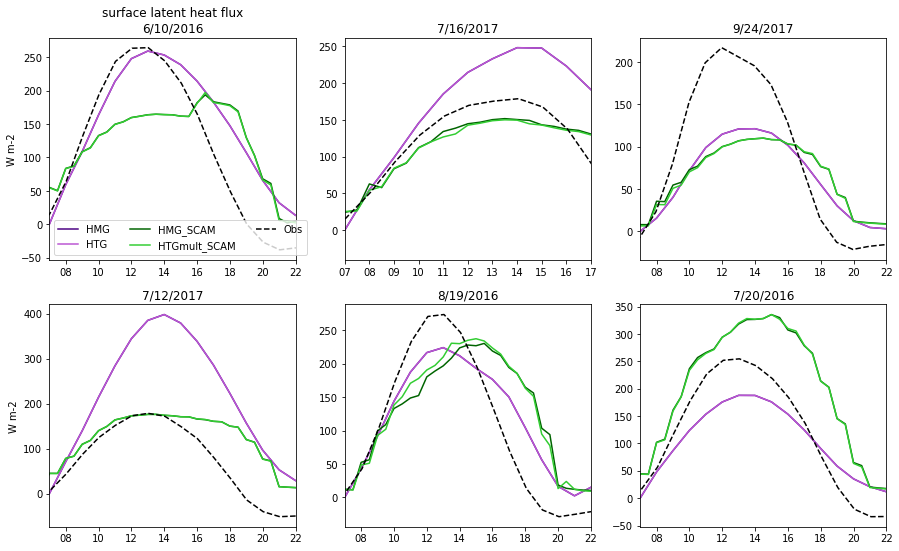

In [32]:
# axs = plotDiurnalCycle_LES('AVS_RAIN', None, 'default', True)
# ## Add SCAM output to the same plots 
# scamVar  = 'PRECT'
# scamMult = 1000.0

axs = plotDiurnalCycle_LES('AVS_LH', None, 'default', True)
## Add SCAM output to the same plots 
scamVar  = 'LHFLX'
scamMult = 1.0


axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )

axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )

axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )

axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )

axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )


axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTGmult_SCAM' )



## Add observations too (LASSO VARANAL)
axs[0].plot(forcDS_20160610.time.values, np.squeeze(forcDS_20160610[obsVar].values),'k--', label='Obs' )
axs[0].legend(ncol=3)

axs[1].plot(forcDS_20170716.time.values, np.squeeze(forcDS_20170716[obsVar].values), 'k--', label='Obs')
# axs[1].legend(ncol=2)

axs[2].plot(forcDS_20170924.time.values, np.squeeze(forcDS_20170924[obsVar].values), 'k--', label='Obs')
# axs[2].legend(ncol=2)

axs[3].plot(forcDS_20170712.time.values, np.squeeze(forcDS_20170712[obsVar].values), 'k--', label='Obs')
# axs[3].legend(ncol=2)

axs[4].plot(forcDS_20160819.time.values, np.squeeze(forcDS_20160819[obsVar].values), 'k--', label='Obs')
# axs[4].legend(ncol=2)

axs[5].plot(forcDS_20160720.time.values, np.squeeze(forcDS_20160720[obsVar].values), 'k--', label='Obs')
# axs[5].legend(ncol=2)


axs[0].set_xlim([LES_allCasesDefault_20160610['Time'].values[0], LES_allCasesDefault_20160610['Time'].values[-1]])
axs[1].set_xlim([LES_allCasesDefault_20170716['Time'].values[0], LES_allCasesDefault_20170716['Time'].values[-1]])
axs[2].set_xlim([LES_allCasesDefault_20170924['Time'].values[0], LES_allCasesDefault_20170924['Time'].values[-1]])
axs[3].set_xlim([LES_allCasesDefault_20170712['Time'].values[0], LES_allCasesDefault_20170712['Time'].values[-1]])
axs[4].set_xlim([LES_allCasesDefault_20160819['Time'].values[0], LES_allCasesDefault_20160819['Time'].values[-1]])
axs[5].set_xlim([LES_allCasesDefault_20160720['Time'].values[0], LES_allCasesDefault_20160720['Time'].values[-1]])


(17002.291666666668, 17002.916666666668)

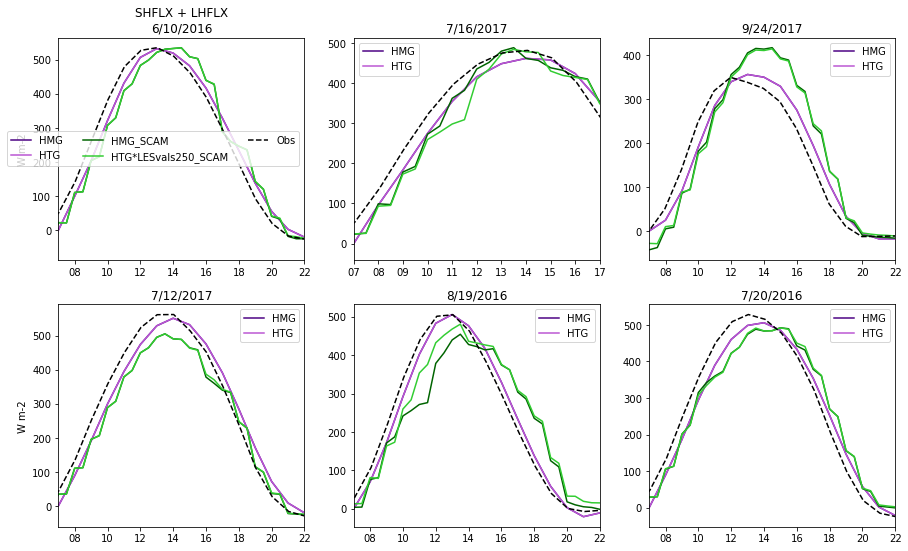

In [33]:
## Sanity check on overall SH+LH


HMGles_20160610 = LES_allCasesDefault_20160610['AVS_SH'].sel(case='HMG').values + LES_allCasesDefault_20160610['AVS_LH'].sel(case='HMG').values
HMGles_20170716 = LES_allCasesDefault_20170716['AVS_SH'].sel(case='HMG').values + LES_allCasesDefault_20170716['AVS_LH'].sel(case='HMG').values
HMGles_20170924 = LES_allCasesDefault_20170924['AVS_SH'].sel(case='HMG').values + LES_allCasesDefault_20170924['AVS_LH'].sel(case='HMG').values
HMGles_20170712 = LES_allCasesDefault_20170712['AVS_SH'].sel(case='HMG').values + LES_allCasesDefault_20170712['AVS_LH'].sel(case='HMG').values
HMGles_20160819 = LES_allCasesDefault_20160819['AVS_SH'].sel(case='HMG').values + LES_allCasesDefault_20160819['AVS_LH'].sel(case='HMG').values
HMGles_20160720 = LES_allCasesDefault_20160720['AVS_SH'].sel(case='HMG').values + LES_allCasesDefault_20160720['AVS_LH'].sel(case='HMG').values

HTGles_20160610 = LES_allCasesDefault_20160610['AVS_SH'].sel(case='HTG').values + LES_allCasesDefault_20160610['AVS_LH'].sel(case='HTG').values
HTGles_20170716 = LES_allCasesDefault_20170716['AVS_SH'].sel(case='HTG').values + LES_allCasesDefault_20170716['AVS_LH'].sel(case='HTG').values
HTGles_20170924 = LES_allCasesDefault_20170924['AVS_SH'].sel(case='HTG').values + LES_allCasesDefault_20170924['AVS_LH'].sel(case='HTG').values
HTGles_20170712 = LES_allCasesDefault_20170712['AVS_SH'].sel(case='HTG').values + LES_allCasesDefault_20170712['AVS_LH'].sel(case='HTG').values
HTGles_20160819 = LES_allCasesDefault_20160819['AVS_SH'].sel(case='HTG').values + LES_allCasesDefault_20160819['AVS_LH'].sel(case='HTG').values
HTGles_20160720 = LES_allCasesDefault_20160720['AVS_SH'].sel(case='HTG').values + LES_allCasesDefault_20160720['AVS_LH'].sel(case='HTG').values

times20160610   = LES_allCasesDefault_20160610.Time
times20170716   = LES_allCasesDefault_20170716.Time
times20170924   = LES_allCasesDefault_20170924.Time
times20170712   = LES_allCasesDefault_20170712.Time
times20160819   = LES_allCasesDefault_20160819.Time
times20160720   = LES_allCasesDefault_20160720.Time

timeString  = 'Time'
unitString  = LES_allCasesDefault['AVS_SH'].units
titleString = 'SHFLX + LHFLX'

HMGles_20160610 = np.nanmean(np.nanmean(HMGles_20160610,axis=1), axis=1)
HMGles_20170716 = np.nanmean(np.nanmean(HMGles_20170716,axis=1), axis=1)
HMGles_20170924 = np.nanmean(np.nanmean(HMGles_20170924,axis=1), axis=1)
HMGles_20170712 = np.nanmean(np.nanmean(HMGles_20170712,axis=1), axis=1)
HMGles_20160819 = np.nanmean(np.nanmean(HMGles_20160819,axis=1), axis=1)
HMGles_20160720 = np.nanmean(np.nanmean(HMGles_20160720,axis=1), axis=1)

HTGles_20160610 = np.nanmean(np.nanmean(HTGles_20160610,axis=1), axis=1)
HTGles_20170716 = np.nanmean(np.nanmean(HTGles_20170716,axis=1), axis=1)
HTGles_20170924 = np.nanmean(np.nanmean(HTGles_20170924,axis=1), axis=1)
HTGles_20170712 = np.nanmean(np.nanmean(HTGles_20170712,axis=1), axis=1)
HTGles_20160819 = np.nanmean(np.nanmean(HTGles_20160819,axis=1), axis=1)
HTGles_20160720 = np.nanmean(np.nanmean(HTGles_20160720,axis=1), axis=1)
                
    
## Plot
fig,axs = plt.subplots(2,3, figsize=(15,9))
axs = axs.ravel()

axs[0].plot(times20160610, HMGles_20160610, color='indigo', label='HMG')
axs[0].plot(times20160610, HTGles_20160610, color='mediumorchid', label='HTG')
axs[0].legend()
axs[0].set_ylabel(unitString)
axs[0].xaxis.set_major_formatter(DateFormatter("%H"))

axs[1].plot(times20170716, HMGles_20170716, color='indigo', label='HMG')
axs[1].plot(times20170716, HTGles_20170716, color='mediumorchid', label='HTG')
axs[1].legend()
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))

axs[2].plot(times20170924, HMGles_20170924, color='indigo', label='HMG')
axs[2].plot(times20170924, HTGles_20170924, color='mediumorchid', label='HTG')
axs[2].legend()
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[3].plot(times20170712, HMGles_20170712, color='indigo', label='HMG')
axs[3].plot(times20170712, HTGles_20170712, color='mediumorchid', label='HTG')
axs[3].legend()
axs[3].set_ylabel(unitString)
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))

axs[4].plot(times20160819, HMGles_20160819, color='indigo', label='HMG')
axs[4].plot(times20160819, HTGles_20160819, color='mediumorchid', label='HTG')
axs[4].legend()
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))

axs[5].plot(times20160720, HMGles_20160720, color='indigo', label='HMG')
axs[5].plot(times20160720, HTGles_20160720, color='mediumorchid', label='HTG')
axs[5].legend()
axs[5].xaxis.set_major_formatter(DateFormatter("%H"))


## Set titles 
axs[0].set_title(titleString+'\n'+
              str(times20160610[timeString+'.month'].values[0])+'/'+
              str(times20160610[timeString+'.day'].values[0])+'/'+
              str(times20160610[timeString+'.year'].values[0])  )

axs[1].set_title('\n'+
              str(times20170716[timeString+'.month'].values[0])+'/'+
              str(times20170716[timeString+'.day'].values[0])+'/'+
              str(times20170716[timeString+'.year'].values[0]) )

axs[2].set_title('\n'+
              str(times20170924[timeString+'.month'].values[0])+'/'+
              str(times20170924[timeString+'.day'].values[0])+'/'+
              str(times20170924[timeString+'.year'].values[0]) )

axs[3].set_title('\n'+
              str(times20170712[timeString+'.month'].values[0])+'/'+
              str(times20170712[timeString+'.day'].values[0])+'/'+
              str(times20170712[timeString+'.year'].values[0]) )

axs[4].set_title('\n'+
              str(times20160819[timeString+'.month'].values[0])+'/'+
              str(times20160819[timeString+'.day'].values[0])+'/'+
              str(times20160819[timeString+'.year'].values[0]) ) 

axs[5].set_title('\n'+
              str(times20160720[timeString+'.month'].values[0])+'/'+
              str(times20160720[timeString+'.day'].values[0])+'/'+
              str(times20160720[timeString+'.year'].values[0]) )


#### Add in SCAM variables
scamVar  = 'LHFLX'

axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HMG')['SHFLX'].values + days_all_20160610.sel(case='HMG')['LHFLX'].values),
            color='darkgreen', label='HMG_SCAM' )
axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HTG*LESvals250')['SHFLX'].values + days_all_20160610.sel(case='HTG*LESvals250')['LHFLX'].values),
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[0].legend(ncol=2)

axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HMG')['SHFLX'].values + days_all_20170716.sel(case='HMG')['LHFLX'].values),
            color='darkgreen', label='HMG_SCAM' )
axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HTG*LESvals250')['SHFLX'].values + days_all_20170716.sel(case='HTG*LESvals250')['LHFLX'].values),
            color='limegreen', label='HTG*LESvals250_SCAM' )

axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HMG')['SHFLX'].values + days_all_20170924.sel(case='HMG')['LHFLX'].values),
            color='darkgreen', label='HMG_SCAM' )
axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HTG*LESvals250')['SHFLX'].values + days_all_20170924.sel(case='HTG*LESvals250')['LHFLX'].values),
            color='limegreen', label='HTG*LESvals250_SCAM' )

axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HMG')['SHFLX'].values + days_all_20170712.sel(case='HMG')['LHFLX'].values),
            color='darkgreen', label='HMG_SCAM' )
axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HTG*LESvals250')['SHFLX'].values + days_all_20170712.sel(case='HTG*LESvals250')['LHFLX'].values),
            color='limegreen', label='HTG*LESvals250_SCAM' )

axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HMG')['SHFLX'].values + days_all_20160819.sel(case='HMG')['LHFLX'].values),
            color='darkgreen', label='HMG_SCAM' )
axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HTG*LESvals250')['SHFLX'].values + days_all_20160819.sel(case='HTG*LESvals250')['LHFLX'].values),
            color='limegreen', label='HTG*LESvals250_SCAM' )

axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HMG')['SHFLX'].values + days_all_20160720.sel(case='HMG')['LHFLX'].values),
            color='darkgreen', label='HMG_SCAM' )
axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HTG*LESvals250')['SHFLX'].values + days_all_20160720.sel(case='HTG*LESvals250')['LHFLX'].values),
            color='limegreen', label='HTG*LESvals250_SCAM' )


## Add observations too (LASSO VARANAL)
axs[0].plot(forcDS_20160610.time.values, np.squeeze(forcDS_20160610['SH'].values+forcDS_20160610['LH'].values),'k--', label='Obs' )
axs[0].legend(ncol=3)

axs[1].plot(forcDS_20170716.time.values, np.squeeze(forcDS_20170716['SH'].values+forcDS_20170716['LH'].values), 'k--', label='Obs')
# axs[1].legend(ncol=2)

axs[2].plot(forcDS_20170924.time.values, np.squeeze(forcDS_20170924['SH'].values+forcDS_20170924['LH'].values), 'k--', label='Obs')
# axs[2].legend(ncol=2)

axs[3].plot(forcDS_20170712.time.values, np.squeeze(forcDS_20170712['SH'].values+forcDS_20170712['LH'].values), 'k--', label='Obs')
# axs[3].legend(ncol=2)

axs[4].plot(forcDS_20160819.time.values, np.squeeze(forcDS_20160819['SH'].values+forcDS_20160819['LH'].values), 'k--', label='Obs')
# axs[4].legend(ncol=2)

axs[5].plot(forcDS_20160720.time.values, np.squeeze(forcDS_20160720['SH'].values+forcDS_20160720['LH'].values), 'k--', label='Obs')
# axs[5].legend(ncol=2)
axs[0].set_xlim([LES_allCasesDefault_20160610['Time'].values[0], LES_allCasesDefault_20160610['Time'].values[-1]])
axs[1].set_xlim([LES_allCasesDefault_20170716['Time'].values[0], LES_allCasesDefault_20170716['Time'].values[-1]])
axs[2].set_xlim([LES_allCasesDefault_20170924['Time'].values[0], LES_allCasesDefault_20170924['Time'].values[-1]])
axs[3].set_xlim([LES_allCasesDefault_20170712['Time'].values[0], LES_allCasesDefault_20170712['Time'].values[-1]])
axs[4].set_xlim([LES_allCasesDefault_20160819['Time'].values[0], LES_allCasesDefault_20160819['Time'].values[-1]])
axs[5].set_xlim([LES_allCasesDefault_20160720['Time'].values[0], LES_allCasesDefault_20160720['Time'].values[-1]])



(17002.291666666668, 17002.916666666668)

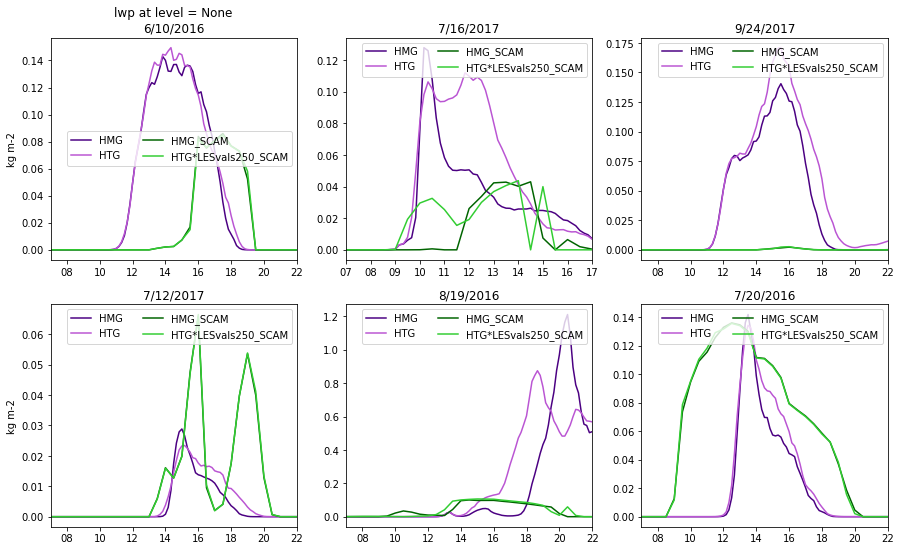

In [46]:
# axs = plotDiurnalCycle_LES('AVS_RAIN', None, 'default', True)
# ## Add SCAM output to the same plots 
# scamVar  = 'PRECT'
# scamMult = 1000.0

axs = plotDiurnalCycle_LES('lwp', None, 'moments', False)
## Add SCAM output to the same plots 
scamVar  = 'TGCLDLWP'
scamMult = 1.0


axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[0].legend(ncol=2)

axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[1].legend(ncol=2)

axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[2].legend(ncol=2)

axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[3].legend(ncol=2)

axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[4].legend(ncol=2)

axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HMG')[scamVar].values)*scamMult,
            color='darkgreen', label='HMG_SCAM' )
axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HTG*LESvals250')[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[5].legend(ncol=2)

axs[0].set_xlim([LES_allCasesDefault_20160610['Time'].values[0], LES_allCasesDefault_20160610['Time'].values[-1]])
axs[1].set_xlim([LES_allCasesDefault_20170716['Time'].values[0], LES_allCasesDefault_20170716['Time'].values[-1]])
axs[2].set_xlim([LES_allCasesDefault_20170924['Time'].values[0], LES_allCasesDefault_20170924['Time'].values[-1]])
axs[3].set_xlim([LES_allCasesDefault_20170712['Time'].values[0], LES_allCasesDefault_20170712['Time'].values[-1]])
axs[4].set_xlim([LES_allCasesDefault_20160819['Time'].values[0], LES_allCasesDefault_20160819['Time'].values[-1]])
axs[5].set_xlim([LES_allCasesDefault_20160720['Time'].values[0], LES_allCasesDefault_20160720['Time'].values[-1]])


(17002.291666666668, 17002.916666666668)

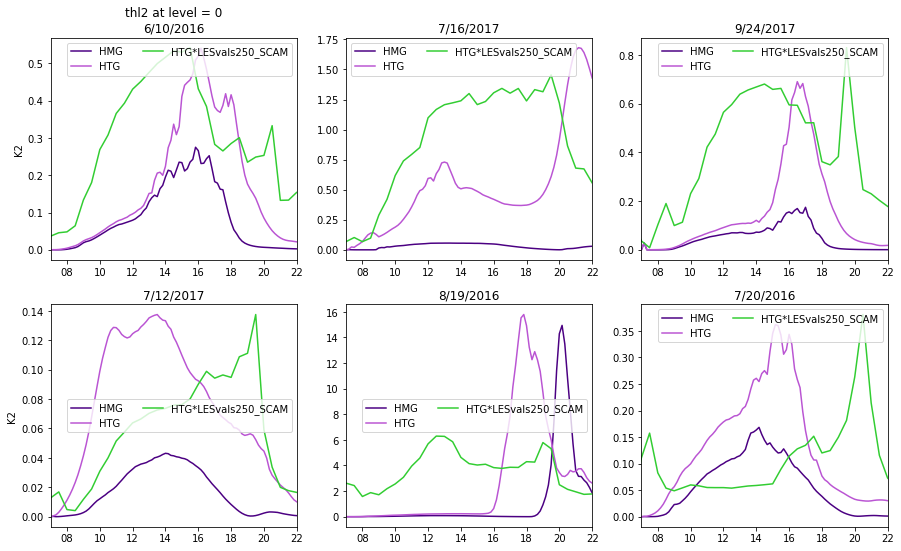

In [39]:
## Plot moments (htg part only)

axs = plotDiurnalCycle_LES('thl2', 0, 'moments', False)

## Add SCAM output to the same plots 
scamVar  = 'THLP2_CLUBB'
scamMult = 1.0
scamLev  = -1


axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-days_all_20160610.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[0].legend(ncol=2)

axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20170716.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[1].legend(ncol=2)

axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20170924.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[2].legend(ncol=2)

axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20170712.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[3].legend(ncol=2)

axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20160819.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[4].legend(ncol=2)

axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20160720.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[5].legend(ncol=2)

axs[0].set_xlim([LES_allCases_20160610['time'].values[0], LES_allCases_20160610['time'].values[-1]])
axs[1].set_xlim([LES_allCases_20170716['time'].values[0], LES_allCases_20170716['time'].values[-1]])
axs[2].set_xlim([LES_allCases_20170924['time'].values[0], LES_allCases_20170924['time'].values[-1]])
axs[3].set_xlim([LES_allCases_20170712['time'].values[0], LES_allCases_20170712['time'].values[-1]])
axs[4].set_xlim([LES_allCases_20160819['time'].values[0], LES_allCases_20160819['time'].values[-1]])
axs[5].set_xlim([LES_allCases_20160720['time'].values[0], LES_allCases_20160720['time'].values[-1]])


(17002.291666666668, 17002.916666666668)

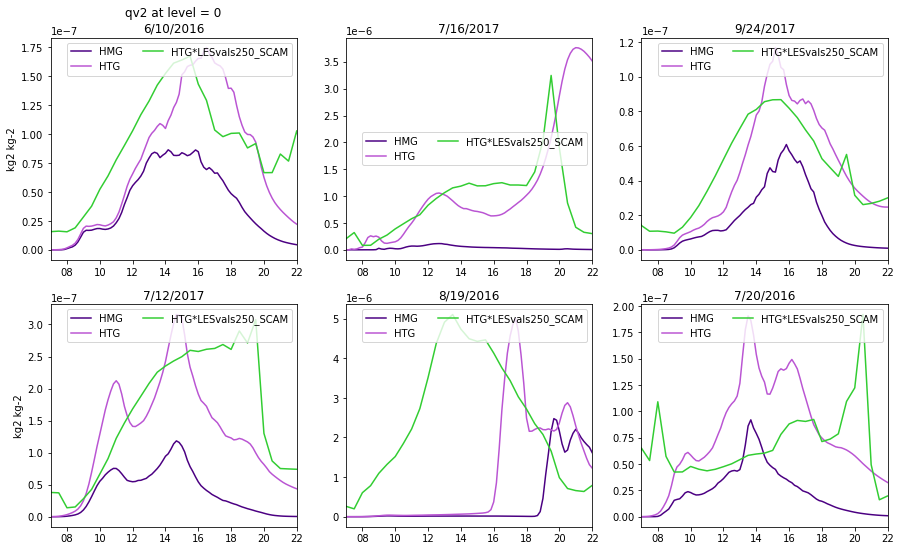

In [41]:
## Plot moments (htg part only)

axs = plotDiurnalCycle_LES('qv2', 0, 'moments', False)

## Add SCAM output to the same plots 
scamVar  = 'RTP2_CLUBB'
scamMult = 1e-6
scamLev  = -1


axs[0].plot(days_all_20160610.time.values, np.squeeze(days_all_20160610.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-days_all_20160610.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[0].legend(ncol=2)

axs[1].plot(days_all_20170716.time.values, np.squeeze(days_all_20170716.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20170716.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[1].legend(ncol=2)

axs[2].plot(days_all_20170924.time.values, np.squeeze(days_all_20170924.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20170924.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[2].legend(ncol=2)

axs[3].plot(days_all_20170712.time.values, np.squeeze(days_all_20170712.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20170712.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[3].legend(ncol=2)

axs[4].plot(days_all_20160819.time.values, np.squeeze(days_all_20160819.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20160819.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[4].legend(ncol=2)

axs[5].plot(days_all_20160720.time.values, np.squeeze(days_all_20160720.sel(case='HTG*LESvals250').isel(ilev=scamLev)[scamVar].values-
                                                      days_all_20160720.sel(case='HMG').isel(ilev=scamLev)[scamVar].values)*scamMult,
            color='limegreen', label='HTG*LESvals250_SCAM' )
axs[5].legend(ncol=2)

axs[0].set_xlim([LES_allCases_20160610['time'].values[0], LES_allCases_20160610['time'].values[-1]])
axs[1].set_xlim([LES_allCases_20170716['time'].values[0], LES_allCases_20170716['time'].values[-1]])
axs[2].set_xlim([LES_allCases_20170924['time'].values[0], LES_allCases_20170924['time'].values[-1]])
axs[3].set_xlim([LES_allCases_20170712['time'].values[0], LES_allCases_20170712['time'].values[-1]])
axs[4].set_xlim([LES_allCases_20160819['time'].values[0], LES_allCases_20160819['time'].values[-1]])
axs[5].set_xlim([LES_allCases_20160720['time'].values[0], LES_allCases_20160720['time'].values[-1]])


## Animations of specific LES days (of the 6 selected)

In [7]:
## Grid spacing, dx and dy, is 250 m (or 0.25 km)
xvals = (LES_allCasesDefault_20160610.west_east.values)*0.250
yvals = (LES_allCasesDefault_20160610.south_north.values)*0.250

NameError: name 'LES_allCasesDefault_20160610' is not defined

**Snapshots**

In [ ]:
def LES_snapshotDiff(pltVar, hrSel, levsDiff):
    
    htg_20160610 = LES_allCasesDefault_20160610.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20160610['Time.hour'].values==hrSel)[0])
    hmg_20160610 = LES_allCasesDefault_20160610.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20160610['Time.hour'].values==hrSel)[0])
    diff_20160610 = htg_20160610 - hmg_20160610

    htg_20170716 = LES_allCasesDefault_20170716.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20170716['Time.hour'].values==hrSel)[0])
    hmg_20170716 = LES_allCasesDefault_20170716.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20170716['Time.hour'].values==hrSel)[0])
    diff_20170716 = htg_20170716 - hmg_20170716

    htg_20170924 = LES_allCasesDefault_20170924.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20170924['Time.hour'].values==hrSel)[0])
    hmg_20170924 = LES_allCasesDefault_20170924.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20170924['Time.hour'].values==hrSel)[0])
    diff_20170924 = htg_20170924 - hmg_20170924

    htg_20170712 = LES_allCasesDefault_20170712.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20170712['Time.hour'].values==hrSel)[0])
    hmg_20170712 = LES_allCasesDefault_20170712.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20170712['Time.hour'].values==hrSel)[0])
    diff_20170712 = htg_20170712 - hmg_20170712

    htg_20160819 = LES_allCasesDefault_20160819.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20160819['Time.hour'].values==hrSel)[0])
    hmg_20160819 = LES_allCasesDefault_20160819.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20160819['Time.hour'].values==hrSel)[0])
    diff_20160819 = htg_20160819 - hmg_20160819
    
    htg_20160720 = LES_allCasesDefault_20160720.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20160720['Time.hour'].values==hrSel)[0])
    hmg_20160720 = LES_allCasesDefault_20160720.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20160720['Time.hour'].values==hrSel)[0])
    diff_20160720 = htg_20160720 - hmg_20160720

    ## Plot options 
    fig,axs = plt.subplots(2,3, figsize=(15,8))
    axs     = axs.ravel()

    ## Plot the difference 
    axs[0].contourf(xvals, yvals, np.squeeze(diff_20160610[pltVar].values), 
                   levsDiff, cmap='bwr', extend='both')

    axs[1].contourf(xvals, yvals, np.squeeze(diff_20170716[pltVar].values), 
                   levsDiff, cmap='bwr', extend='both')

    axs[2].contourf(xvals, yvals, np.squeeze(diff_20170924[pltVar].values), 
               levsDiff, cmap='bwr', extend='both')
    
    
    axs[3].contourf(xvals, yvals, np.squeeze(diff_20170712[pltVar].values), 
               levsDiff, cmap='bwr', extend='both')
    
    cplt2 = axs[4].contourf(xvals, yvals, np.squeeze(diff_20160819[pltVar].values), 
                           levsDiff, cmap='bwr', extend='both')
    # Add colorbar
    ax_position = axs[4].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.1, ax_position.width+0.17, 0.03])
    cbar = plt.colorbar(cplt2, orientation='horizontal',cax=cbar_ax, label=LES_allCasesDefault[pltVar].units)
    cbar.ax.tick_params(labelsize=12) 
    
    axs[5].contourf(xvals, yvals, np.squeeze(diff_20160720[pltVar].values), 
               levsDiff, cmap='bwr', extend='both')

    ## Set titles 
    axs[0].set_title('HTG-HMG: '+LES_allCasesDefault[pltVar].description+'\n'+
                  str(diff_20160610['Time.month'].values[0])+'/'+
                  str(diff_20160610['Time.day'].values[0])+': Local Hour '+
                  str(diff_20160610['Time.hour'].values[0]) )

    axs[1].set_title('\n'+
                  str(diff_20170716['Time.month'].values[0])+'/'+
                  str(diff_20170716['Time.day'].values[0])+': Local Hour '+
                  str(diff_20170716['Time.hour'].values[0]) )

    axs[2].set_title('\n'+
                  str(diff_20170924['Time.month'].values[0])+'/'+
                  str(diff_20170924['Time.day'].values[0])+': Local Hour '+
                  str(diff_20170924['Time.hour'].values[0]) )
    
    axs[3].set_title('HTG-HMG: '+LES_allCasesDefault[pltVar].description+'\n'+
                  str(diff_20170712['Time.month'].values[0])+'/'+
                  str(diff_20170712['Time.day'].values[0])+': Local Hour '+
                  str(diff_20170712['Time.hour'].values[0]) )

    axs[4].set_title('\n'+
                  str(diff_20160819['Time.month'].values[0])+'/'+
                  str(diff_20160819['Time.day'].values[0])+': Local Hour '+
                  str(diff_20160819['Time.hour'].values[0]) )

    axs[5].set_title('\n'+
                  str(diff_20160720['Time.month'].values[0])+'/'+
                  str(diff_20160720['Time.day'].values[0])+': Local Hour '+
                  str(diff_20160720['Time.hour'].values[0]) )


    return

In [19]:
# ## Plot HTG-HMG difference per day at a selected hour 

# pltVar = 'AVS_SH'
# hrSel  = 13

# # levsDiff = np.arange(-0.1,0.11,0.01)   ## AVS_LWP
# levsDiff = np.arange(-110,111,1)   ## AVS_SH
# # levsDiff = np.arange(-2e-5, 2.05e-5, 0.05e-5)   ## AVS_RAIN



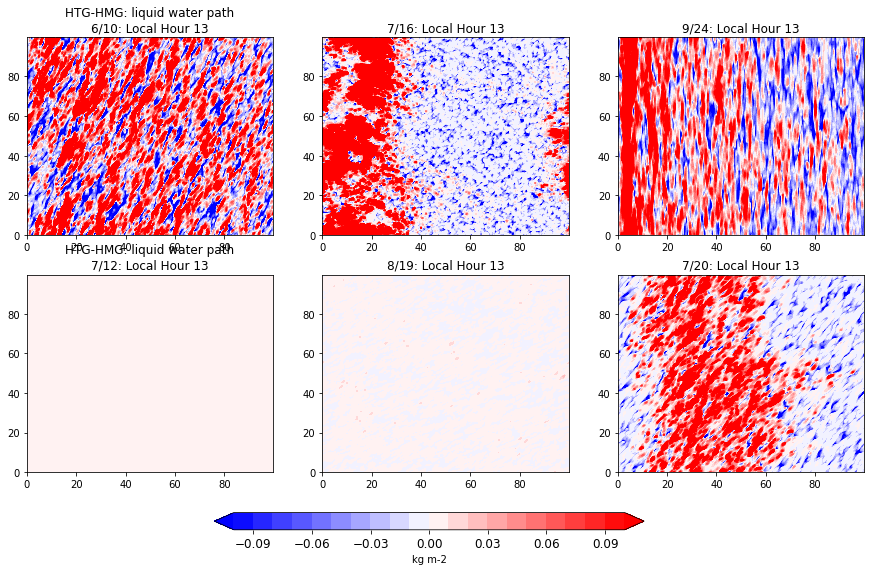

In [23]:
# LES_snapshotDiff('AVS_SH', 13, np.arange(-110,111,1) )

LES_snapshotDiff('AVS_LWP', 13, np.arange(-0.1,0.11,0.01) )



**Animation**

In [20]:
def drawMap(pltVar, pltDS, testDS, ctrlDS, diffDS, levsC, levsCdiff, cmapRaw, timeSel):
    
    ## Plot raw values 
    axs[0].contourf(xvals, yvals, ctrlDS.isel(Time=timeSel).values, 
                   levsC, cmap=cmapRaw, extend='both')

    cplt = axs[1].contourf(xvals, yvals, testDS.isel(Time=timeSel).values, 
                   levsC, cmap=cmapRaw, extend='both')

    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=pltDS[pltVar].units)
    cbar.ax.tick_params(labelsize=12) 

    axs[0].set_title(pltCaseCtrl+': '+pltDS[pltVar].description+'\n'+
                  str(pltDS['Time.month'].values[timeSel])+'/'+
                  str(pltDS['Time.day'].values[timeSel])+': Local Hour '+
                  str(pltDS['Time.hour'].values[timeSel]) )

    axs[1].set_title(pltCaseTest+': '+pltDS[pltVar].description+'\n'+
                  str(pltDS['Time.month'].values[timeSel])+'/'+
                  str(pltDS['Time.day'].values[timeSel])+': Local Hour '+
                  str(pltDS['Time.hour'].values[timeSel]) )


    ## Plot the difference 
    cplt = axs[2].contourf(xvals, yvals, diffDS.isel(Time=timeSel).values, 
                   levsCdiff, cmap='bwr', extend='both')
    # Add colorbar
    ax_position = axs[2].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=pltDS[pltVar].units)
    cbar.ax.tick_params(labelsize=12) 

    axs[2].set_title(pltCaseTest+'-'+pltCaseCtrl+': '+pltDS[pltVar].description+'\n'+
                  str(pltDS['Time.month'].values[timeSel])+'/'+
                  str(pltDS['Time.day'].values[timeSel])+': Local Hour '+
                  str(pltDS['Time.hour'].values[timeSel]) )

    return

def animate(frame):
    return drawMap(pltVar, pltDS, testDS, ctrlDS, diffDS, levsC, levsCdiff, cmapRaw, frame)

In [ ]:
# LES_allCasesDefault_20160610
# LES_allCasesDefault_20170716
# LES_allCasesDefault_20170924

# LES_allCasesDefault_20170712
# LES_allCasesDefault_20160819
# LES_allCasesDefault_20160720


In [51]:
fig,axs = plt.subplots(1,3, figsize=(20,7))
axs     = axs.ravel()

pltVar      = 'AVS_SH'
pltDS       = LES_allCasesDefault_20160720
dateString  = '20160720'
pltCaseTest = 'HTG'
pltCaseCtrl = 'HMG' 
cmapRaw     = 'viridis'

testDS = pltDS.sel(case=pltCaseTest)[pltVar]
ctrlDS = pltDS.sel(case=pltCaseCtrl)[pltVar]

## Get levels to plot 
levsMinRaw = np.nanpercentile(pltDS[pltVar], 10)
levsMaxRaw = np.nanpercentile(pltDS[pltVar], 99)
levsC      = np.arange(levsMinRaw, levsMaxRaw, (levsMaxRaw-levsMinRaw)/100)

diffDS = testDS - ctrlDS
levsMaxDiff = np.nanpercentile(diffDS.values, 95) 
levsMinDiff = np.nanpercentile(diffDS.values, 5) 
levsEvenDiff = np.nanmax([np.abs(levsMaxDiff), np.abs(levsMinDiff)])
cstep        = (2*levsEvenDiff)/100
levsCdiff    = np.arange(-levsEvenDiff, levsEvenDiff+cstep, cstep)

frames = len(pltDS.Time.values)
ani = animation.FuncAnimation(fig, animate, frames, interval=1, blit=False,
                              repeat=False)

# ani.save('TestAnimation_HTGminusHMG_'+pltVar+'.mp4', writer=animation.FFMpegWriter(fps=8))
writergif = animation.PillowWriter(fps=1) 
ani.save('../CLASP_animations/'+pltVar+'_'+dateString+'.gif', writer=writergif)

plt.close(fig)

In [32]:
fig,axs = plt.subplots(1,3, figsize=(20,7))
axs     = axs.ravel()

# pltVar      = 'AVS_LWP'
pltVar      = 'AVS_RAIN'
pltDS       = LES_allCasesDefault_20160720
dateString  = '20160720'
pltCaseTest = 'HTG'
pltCaseCtrl = 'HMG' 
cmapRaw     = 'viridis'

testDS = pltDS.sel(case=pltCaseTest)[pltVar]
ctrlDS = pltDS.sel(case=pltCaseCtrl)[pltVar]

## Get levels to plot 
levsMinRaw = np.nanpercentile(pltDS[pltVar], 10)
levsMaxRaw = np.nanpercentile(pltDS[pltVar], 99)
levsC      = np.arange(levsMinRaw, levsMaxRaw, (levsMaxRaw-levsMinRaw)/100)

diffDS       = testDS - ctrlDS
levsMaxDiff  = np.nanpercentile(diffDS.values, 95) 
levsMinDiff  = np.nanpercentile(diffDS.values, 5) 
levsEvenDiff = np.nanmax([np.abs(levsMaxDiff), np.abs(levsMinDiff)])
cstep        = (2*levsEvenDiff)/100
levsCdiff    = np.arange(-levsEvenDiff, levsEvenDiff+cstep, cstep)

frames = len(pltDS.Time.values)
ani = animation.FuncAnimation(fig, animate, frames, interval=1, blit=False,
                              repeat=False)

# ani.save('TestAnimation_HTGminusHMG_'+pltVar+'.mp4', writer=animation.FFMpegWriter(fps=8))
writergif = animation.PillowWriter(fps=1) 
ani.save('../CLASP_animations/'+pltVar+'_'+dateString+'.gif', writer=writergif)

plt.close(fig)

## Maybe we need all the days... 

In [7]:
## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                      'U10','CLDHGH','CLDLIQ','TMQ'])

In [8]:
circulationTXT = '/glade/work/mdfowler/CLASP/LESdata_fromJason/circulations.txt'

circMetric = pd.read_csv(circulationTXT, sep=" ", header=None)
circMetric.columns = ['dateVal', 'metricVal']

allYears   = [] 
allMonths  = []
allDays    = []

for iDate in range(len(circMetric.dateVal)):
    allYears   = np.append(allYears,   circMetric.dateVal.values.astype(str)[iDate][0:4]) 
    allMonths  = np.append(allMonths, circMetric.dateVal.values.astype(str)[iDate][4:6])
    allDays    = np.append(allDays, circMetric.dateVal.values.astype(str)[iDate][6::])



In [22]:
len(circMetric.metricVal.values)

92

In [44]:
## Get all dates that will have extra data
valCount = 0 
for iDate in range(len(allYears)): 
    
    if ((int(allYears[iDate])>=2016) & (int(allYears[iDate])<=2017)): 
        thisDate = datetime.datetime(int(allYears[iDate]),
                                 int(allMonths[iDate]),
                                 int(allDays[iDate]))

        if valCount==0:
            allDates = thisDate
        else:
            allDates = np.append(allDates, thisDate)
        valCount = valCount+1
        

allDates = np.sort(allDates)

In [58]:
dateVals      = pd.DatetimeIndex(allDates)
dateValsStart = dateVals -  timedelta(days=1)

In [62]:
dateValsStart.day

Int64Index([17, 29,  9, 10, 13, 18, 24, 15, 18, 19, 17, 18, 29,  2,  4,  8, 23,
            26,  4,  8, 13, 25, 26, 28, 29,  3,  4,  8, 11, 15, 16, 18, 19, 20,
            24, 27,  1, 25, 27, 29, 21, 22, 23],
           dtype='int64')

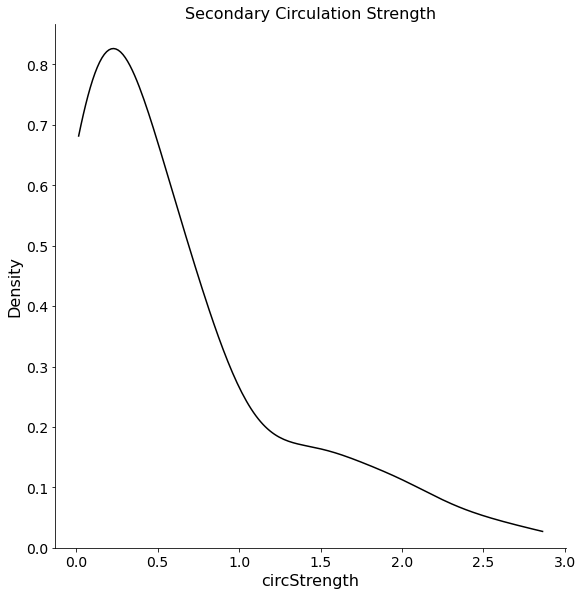

In [22]:
# # Define dataframe

# g = sns.displot(pd.DataFrame.from_dict({'circStrength': np.squeeze(circMetric.metricVal)}), 
#                 x='circStrength', kind='kde', height=8, cut=0,
#                 color='k')


# g.ax.set_title("Secondary Circulation Strength", fontsize=16 ) 
# g.ax.set_xlabel('circStrength',fontsize=16)
# g.ax.set_ylabel('Density',fontsize=16)
# g.ax.tick_params(axis='both', labelsize= 14)
# # plt.setp(g._legend.get_title(), fontsize=14)
# # plt.setp(g._legend.get_texts(), fontsize=14)

# # g.ax.axvline(circMetric.metricVal.values[np.where(circMetric.dateVal.values==20160610)[0]], color='red')
# # g.ax.axvline(circMetric.metricVal.values[np.where(circMetric.dateVal.values==20170716)[0]], color='limegreen')
# # g.ax.axvline(circMetric.metricVal.values[np.where(circMetric.dateVal.values==20170924)[0]], color='blue')


In [10]:
lesDir        = '/glade/work/mdfowler/CLASP/LESdata_fromJason/allDays_250mRes/'
lesDefaultDir = '/glade/scratch/mdfowler/CLASP_LESoutput/defaultOutput/hydrology.cee.duke.edu/'
archiveDir    = '/glade/scratch/mdfowler/archive/'

# lesDir = '/glade/scratch/mdfowler/CLASP_LESoutput/'

## Fix time arrays to be useful in the LES cases
startTime = datetime.datetime(2016,1,1, 0,0,0)

# Empty arrays: 
dailymax_LES_thl2 = []
dailymax_LES_qv2  = [] 
dateStringsUsed   = []
circMetric_daysUsed = []
circMetric_daysUsed_defMatch = []
dailyMax_SCAMhtg_thlp2 = []
dailyMax_SCAMhtg_rtp2  = []

## Counter for how many days have default output
numDaysDefault = 0

for iDay in range(len(allYears)): 
# for iDay in range(9): 
     
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    ## First: read LES data (surface thl2 and qv2) 
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    dateString = allYears[iDay]+allMonths[iDay]+allDays[iDay]
    
    
    if ( (int(allYears[iDay])<2019) & (int(allMonths[iDay])>=6) & (int(allMonths[iDay])<=8)) :
        if ( (int(allMonths[iDay])<=8) & (int(allDays[iDay])<=29) ):

            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            ## First: read LES data (surface thl2 and qv2) 
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

            HTGds_thl2 = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_00.nc', decode_times=False).isel(k=0)['thl2']
            HMGds_thl2 = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_01.nc', decode_times=False).isel(k=0)['thl2']

            HTGds_qv2 = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_00.nc', decode_times=False).isel(k=0)['qv2']
            HMGds_qv2 = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_01.nc', decode_times=False).isel(k=0)['qv2']
            
            HTGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_00.nc', decode_times=False)
            HMGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_01.nc', decode_times=False)

            HTGds_thl2 = HTGds_thl2.assign_coords({"case": 'HTG'})
            HMGds_thl2 = HMGds_thl2.assign_coords({"case": 'HMG'})

            HTGds_qv2 = HTGds_qv2.assign_coords({"case": 'HTG'})
            HMGds_qv2 = HMGds_qv2.assign_coords({"case": 'HMG'})
            
            HTGds_allVars = HTGds_allVars.assign_coords({"case": 'HTG'})
            HMGds_allVars = HMGds_allVars.assign_coords({"case": 'HMG'})

            LES_thl2 = xr.concat([HMGds_thl2, HTGds_thl2], "case")
            LES_qv2  = xr.concat([HMGds_qv2,  HTGds_qv2], "case")
            
            LES_allVars = xr.concat([HMGds_allVars, HTGds_allVars], "case")
            
            ## Also get some of the default data (if available)
            HTGdir = lesDefaultDir+'doz_'+dateString+'_00/'
            HMGdir = lesDefaultDir+'doz_'+dateString+'_01/'
            
            if os.path.isdir(HTGdir)==True: 
                
                HMGds_xtime = xr.open_dataset(HMGdir+'diag_selectVars.nc', decode_times=False)['XTIME']
                HTGds_xtime = xr.open_dataset(HTGdir+'diag_selectVars.nc', decode_times=False)['XTIME']
                
                HMGds_shflx = xr.open_dataset(HMGdir+'diag_selectVars.nc', decode_times=False)['AVS_SH']
                HTGds_shflx = xr.open_dataset(HTGdir+'diag_selectVars.nc', decode_times=False)['AVS_SH']

                HMGds_lhflx = xr.open_dataset(HMGdir+'diag_selectVars.nc', decode_times=False)['AVS_LH']
                HTGds_lhflx = xr.open_dataset(HTGdir+'diag_selectVars.nc', decode_times=False)['AVS_LH']

                HMGds_lwp = xr.open_dataset(HMGdir+'diag_selectVars.nc', decode_times=False)['AVS_LWP']
                HTGds_lwp = xr.open_dataset(HTGdir+'diag_selectVars.nc', decode_times=False)['AVS_LWP']

                HMGds_rain = xr.open_dataset(HMGdir+'diag_selectVars.nc', decode_times=False)['AVS_RAIN']
                HTGds_rain = xr.open_dataset(HTGdir+'diag_selectVars.nc', decode_times=False)['AVS_RAIN']
                
                ## COMBINE? 
                HMGds_LESdef = xr.merge([HMGds_xtime, HMGds_shflx, HMGds_lhflx, HMGds_lwp, HMGds_rain])
                HTGds_LESdef = xr.merge([HTGds_xtime, HTGds_shflx, HTGds_lhflx, HTGds_lwp, HTGds_rain])

                HMGds_LESdef = HMGds_LESdef.set_index(Time='XTIME').assign_coords({"case": 'HMG'})
                HTGds_LESdef = HTGds_LESdef.set_index(Time='XTIME').assign_coords({"case": 'HTG'})
                
                LES_default  = xr.concat([HMGds_LESdef, HTGds_LESdef], "case")
                
            else:
                print('No default data available for this date...')

            
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            ## Also get SCAM data for these days if available 
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

            # Move day back by one, pad with zero if necessary? 
            SCAM_dateStart = datetime.datetime(int(allYears[iDay]),int(allMonths[iDay]),int(allDays[iDay])) - timedelta(days=1)        

            case_mult = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens'+str(SCAM_dateStart.year)+'_start'+str(SCAM_dateStart.month).zfill(2)+str(SCAM_dateStart.day).zfill(2)+'_pert00/',
                         'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+str(SCAM_dateStart.year)+'_start'+str(SCAM_dateStart.month).zfill(2)+str(SCAM_dateStart.day).zfill(2)+'_pert00/' ]
            caseMult_names = ['HMG','HTG*01']

            for iCase in range(len(caseMult_names)): 
                ## Get list of input files 
                listFiles_camh1 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h1*'))
                listFiles_camh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h0*'))

                ## Should only be one file per glob above (ran for two days), so just open each DS here
                iFile = 0 
                with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as multDS: 
                    multDS         = cesm_correct_time(multDS)
                    multDS['time'] = multDS.indexes['time'].to_datetimeindex() 

                ## Add variables as needed (some are on h0 file stream)
                for iVar in range(len(addVars)):
                    varMult         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
                    varMult['time'] = multDS['time']

                    multDS = xr.merge([multDS, varMult])

                ## Select the second simulated day for analysis 
                iTimeStart_day2  = np.where( (multDS.time.values >= (multDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                             (multDS.time.values <= (multDS.time.values[0] + np.timedelta64(2,'D'))))[0]

                multDS      = multDS.isel(time=iTimeStart_day2)

                ## Process data 
                procDS = process_camData( multDS )

                ## Give case attribute and combine 
                procDS     = procDS.assign_coords({"case":     caseMult_names[iCase]})
                if iCase==0: 
                    multDS_allCases     = procDS
                else:
                    multDS_allCases     = xr.concat([multDS_allCases,     procDS], "case")

                del multDS
                
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            ## Also get forcing data and observations
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            iDay_forcDS   = np.where( (forcDS['time.year']==int(allYears[iDay])) & 
                                      (forcDS['time.month']==int(allMonths[iDay])) & 
                                      (forcDS['time.day']==int(allDays[iDay])) )[0]
            forcDS_daySel = forcDS.isel(time=iDay_forcDS)
            

            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            ## Just a few more processing steps 
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

            ## Convert to local times (SCAM)...
            # - - - - - - - - - - - - - - 
            # Compute local time 
            localTimes = multDS_allCases['time'].values - np.timedelta64(5,'h')
            # Replace time dimension with local time
            multDS_allCases    = multDS_allCases.assign_coords({"time": localTimes})
            
            
            ## Get a better time dimension to use  (LES)
            times_LESday = [] 
            for iT in range(len(LES_thl2.time.values)): 
                timeStep     = startTime + timedelta(minutes = int(LES_thl2.time.values[iT])) - timedelta(hours = 5)   ## Also convert to local time 
                times_LESday = np.append(times_LESday, timeStep)

            LES_thl2['datetime'] = (('time'), times_LESday)
            LES_thl2             = LES_thl2.set_index(time='datetime')

            LES_qv2['datetime'] = (('time'), times_LESday)
            LES_qv2             = LES_qv2.set_index(time='datetime')
            
            LES_allVars['datetime'] = (('time'), times_LESday)
            LES_allVars             = LES_allVars.set_index(time='datetime')
            
            if os.path.isdir(HTGdir)==True:
                startTime_LESdefault = datetime.datetime(multDS_allCases['time.year'].values[0],
                                                         multDS_allCases['time.month'].values[0],
                                                         multDS_allCases['time.day'].values[0], 
                                                         (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST
                
                Times_LESdefault = [] 
                for iT in range(len(LES_default.Time.values)): 
                    timeStep       = startTime_LESdefault+timedelta(minutes = int(LES_default.Time.values[iT]))
                    Times_LESdefault = np.append(Times_LESdefault, timeStep)
                    
                LES_default['datetime'] = (('Time'), Times_LESdefault)
                LES_default             = LES_default.set_index(Time='datetime')
                
                circMetric_daysUsed_defMatch = np.append(circMetric_daysUsed_defMatch, circMetric.metricVal.values[iDay])


            ## Save daily max values...
            dailymax_LES_thl2 = np.append(dailymax_LES_thl2, np.nanmax(LES_thl2.sel(case='HTG')))
            dailymax_LES_qv2  = np.append(dailymax_LES_qv2, np.nanmax(LES_qv2.sel(case='HTG')))
            dateStringsUsed   = np.append(dateStringsUsed,   dateString)
            circMetric_daysUsed = np.append(circMetric_daysUsed, circMetric.metricVal.values[iDay])

            dailyMax_SCAMhtg_thlp2 = np.append(dailyMax_SCAMhtg_thlp2, np.nanmax(multDS_allCases.sel(case='HTG*01').isel(ilev=-1).THLP2_CLUBB.values-
                                                                                 multDS_allCases.sel(case='HMG').isel(ilev=-1).THLP2_CLUBB.values))
            dailyMax_SCAMhtg_rtp2  = np.append(dailyMax_SCAMhtg_rtp2,  np.nanmax(multDS_allCases.sel(case='HTG*01').isel(ilev=-1).RTP2_CLUBB.values-
                                                                                 multDS_allCases.sel(case='HMG').isel(ilev=-1).RTP2_CLUBB.values))


            ## Combine into one array 
            if iDay==0: 
                LES_allDays_thl2 = LES_thl2
                LES_allDays_qv2  = LES_qv2
                LES_allDays_allVars = LES_allVars

                SCAM_allDays     = multDS_allCases
                
                forcDS_allDays   = forcDS_daySel
            else:
                LES_allDays_thl2 = xr.concat([LES_allDays_thl2, LES_thl2], "time")
                LES_allDays_qv2  = xr.concat([LES_allDays_qv2,  LES_qv2], "time")
                LES_allDays_allVars = xr.concat([LES_allDays_allVars, LES_allVars], "time")
                
                SCAM_allDays     = xr.concat([SCAM_allDays, multDS_allCases], "time")
                
                forcDS_allDays   = xr.concat([forcDS_allDays, forcDS_daySel], "time") 
                
            if os.path.isdir(HTGdir)==True: 
                if numDaysDefault==0:
                    LESdefault_allDays = LES_default
                    
                    numDaysDefault = numDaysDefault+1
                else: 
                    LESdefault_allDays = xr.concat([LESdefault_allDays, LES_default], "Time")
                    
                    numDaysDefault = numDaysDefault+1

            del LES_thl2,LES_qv2,multDS_allCases
            
            if os.path.isdir(HTGdir)==True: 
                del LES_default
                
            print('Done with ', dateString)
    else:
        print('Skipping '+dateString)
        
    

No default data available for this date...
Beginning interpolation...
Beginning interpolation...
Done with  20150606
No default data available for this date...
Beginning interpolation...
Beginning interpolation...
Done with  20150609
No default data available for this date...
Beginning interpolation...
Beginning interpolation...
Done with  20150627
No default data available for this date...
Beginning interpolation...
Beginning interpolation...
Done with  20150801
No default data available for this date...
Beginning interpolation...
Beginning interpolation...
Done with  20150829
Skipping 20160518
Skipping 20160530
Beginning interpolation...
Beginning interpolation...
Done with  20160610
Beginning interpolation...
Beginning interpolation...
Done with  20160611
Beginning interpolation...
Beginning interpolation...
Done with  20160614
Beginning interpolation...
Beginning interpolation...
Done with  20160619
Beginning interpolation...
Beginning interpolation...
Done with  20160625
Beginning

In [45]:
# ## Sanity check that this read in option is working as expected 
# print('Date          LESmax     SCAMmax     circMetric')
# for i in range(len(dateStringsUsed)):
#     print('%s %10.3f %10.3f %12.3f' % (dateStringsUsed[i],dailymax_LES_thl2[i],dailyMax_SCAMhtg_thlp2[i],circMetric_daysUsed[i]))


Date          LESmax     SCAMmax     circMetric
20150606      0.767      0.134        0.045
20150609      2.950      0.210        0.612
20150627      0.179      0.120        0.390
20150801      7.569      0.082        2.863
20150829      0.164      0.065        0.414
20160610      0.541      0.109        0.283
20160611      0.407      0.112        0.350


In [11]:
## What's the expected multiplier for each day? 
SCAMmultiplier_thl2 = dailymax_LES_thl2/dailyMax_SCAMhtg_thlp2
SCAMmultiplier_qv2  = (dailymax_LES_qv2*1e6)/dailyMax_SCAMhtg_rtp2


In [25]:
print('Number of days compared: ', len(dateStringsUsed))
print('Number of days with default data: ', numDaysDefault)

Number of days compared:  48
Number of days with default data:  30


In [21]:
dateStringsUsed.astype(int)

array([20150606, 20150609, 20150627, 20150801, 20150829, 20160610,
       20160611, 20160614, 20160619, 20160625, 20160716, 20160719,
       20160720, 20160818, 20160819, 20170605, 20170609, 20170614,
       20170626, 20170627, 20170629, 20170704, 20170705, 20170709,
       20170712, 20170716, 20170717, 20170719, 20170720, 20170721,
       20170725, 20170728, 20170802, 20170826, 20170828, 20180606,
       20180618, 20180619, 20180704, 20180705, 20180707, 20180709,
       20180710, 20180711, 20180712, 20180805, 20180809, 20180811])

Text(0, 0.5, 'Bin Count')

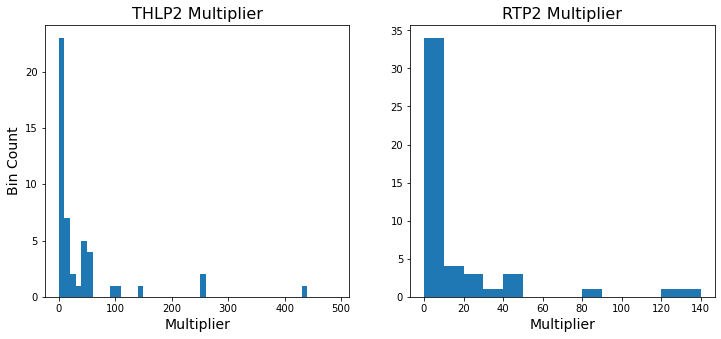

In [13]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

binsTHL2 = np.arange(0,500,10)
binsQV2  = np.arange(0,150,10)

axs[0].hist(SCAMmultiplier_thl2, bins=binsTHL2)
axs[1].hist(SCAMmultiplier_qv2, bins=binsQV2)

axs[0].set_title('THLP2 Multiplier',fontsize=16)
axs[1].set_title('RTP2 Multiplier',fontsize=16)

axs[0].set_xlabel('Multiplier',fontsize=14)
axs[1].set_xlabel('Multiplier',fontsize=14)
axs[0].set_ylabel('Bin Count', fontsize=14)


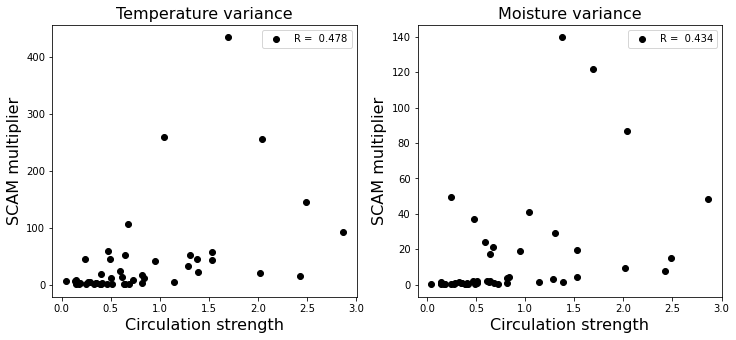

In [30]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

xVar   = circMetric_daysUsed
xLabel = 'Circulation strength'

axs[0].plot(xVar, SCAMmultiplier_thl2, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2)[0,1])])



In [59]:
LESdefault_allDays

<xarray.Dataset>
Dimensions:   (Time: 480, case: 2, south_north: 400, west_east: 400)
Coordinates:
  * Time      (Time) datetime64[ns] 2016-06-10T07:00:00 ... 2017-08-28T22:00:00
  * case      (case) object 'HMG' 'HTG'
Dimensions without coordinates: south_north, west_east
Data variables:
    AVS_SH    (case, Time, south_north, west_east) float32 0.0 0.0 ... -23.28
    AVS_LH    (case, Time, south_north, west_east) float32 0.0 0.0 ... 0.5521
    AVS_LWP   (case, Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    AVS_RAIN  (case, Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    SHgrid    (case, Time) float32 0.0 40.59 94.68 ... -24.17 -25.91 -21.68
    LHgrid    (case, Time) float32 0.0 59.26 108.6 163.5 ... 46.58 12.46 2.585
    EFgrid    (case, Time) float32 nan 0.5935 0.5343 ... 2.078 -0.9267 -0.1354
    RAINgrid  (case, Time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    LWPgrid   (case, Time) float32 0.0 0.0 0.0 ... 4.338e-06 2.183e-09 0.0

In [12]:
## Get the same dates in the SCAM array as in the LES default DS 

for iDay in range(len(LESdefault_allDays.Time.values)):
    thisDay = datetime.datetime(LESdefault_allDays['Time.year'].values[iDay],
                                LESdefault_allDays['Time.month'].values[iDay],
                                LESdefault_allDays['Time.day'].values[iDay])
    
    if iDay==0:
        
        iMatchLES = np.where(  (LES_allDays_thl2['time.year']==thisDay.year) &
                               (LES_allDays_thl2['time.month']==thisDay.month) & 
                               (LES_allDays_thl2['time.day']==thisDay.day) )[0]
        
        hrStart = np.nanmin(LES_allDays_thl2.isel(time=iMatchLES)['time.hour'].values)
        hrEnd   = np.nanmax(LES_allDays_thl2.isel(time=iMatchLES)['time.hour'].values)
        
        iMatch = np.where( (SCAM_allDays['time.year']==thisDay.year) &
                           (SCAM_allDays['time.month']==thisDay.month) & 
                           (SCAM_allDays['time.day']==thisDay.day) & 
                           (SCAM_allDays['time.hour']>=hrStart) & 
                           (SCAM_allDays['time.hour']<=hrEnd) )[0]
        
        iMatchObs = np.where( (forcDS_allDays['time.year']==thisDay.year) &
                              (forcDS_allDays['time.month']==thisDay.month) & 
                              (forcDS_allDays['time.day']==thisDay.day) & 
                              (forcDS_allDays['time.hour']>=hrStart) & 
                              (forcDS_allDays['time.hour']<=hrEnd) )[0]
        
        
        SCAM_matchDefaultLES          = SCAM_allDays.isel(time=iMatch)
        LES_allDays_thl2_matchDefault = LES_allDays_thl2.isel(time=iMatchLES)
        LES_allDays_qv2_matchDefault  = LES_allDays_qv2.isel(time=iMatchLES)
        LES_allDays_allVars_matchDefault = LES_allDays_allVars.isel(time=iMatchLES)
        forcDS_matchDefaultLES        = forcDS_allDays.isel(time=iMatchObs)
        
        matchDays_default =  thisDay
        
        ## Get some daily values
        # thisDayLES = LESdefault_allDays.sel(case='HMG').isel(Time=iMatchLES) 
        # dailyMax_LEShmg_sh = np.append(dailyMax_LES_sh, np.nanmax( ) )
    else: 
        if thisDay==prevDay:
            print('Day already saved...')
        else:
            iMatchLES = np.where(  (LES_allDays_thl2['time.year']==thisDay.year) &
                                   (LES_allDays_thl2['time.month']==thisDay.month) & 
                                   (LES_allDays_thl2['time.day']==thisDay.day) )[0]
            
            hrStart = np.nanmin(LES_allDays_thl2.isel(time=iMatchLES)['time.hour'].values)
            hrEnd   = np.nanmax(LES_allDays_thl2.isel(time=iMatchLES)['time.hour'].values)
        
            iMatch = np.where( (SCAM_allDays['time.year']==thisDay.year) &
                           (SCAM_allDays['time.month']==thisDay.month) & 
                           (SCAM_allDays['time.day']==thisDay.day) & 
                           (SCAM_allDays['time.hour']>=hrStart) & 
                           (SCAM_allDays['time.hour']<=hrEnd) )[0]
            
            iMatchObs = np.where( (forcDS_allDays['time.year']==thisDay.year) &
                              (forcDS_allDays['time.month']==thisDay.month) & 
                              (forcDS_allDays['time.day']==thisDay.day) & 
                              (forcDS_allDays['time.hour']>=hrStart) & 
                              (forcDS_allDays['time.hour']<=hrEnd) )[0]
        
            SCAM_matchDefaultLES = xr.concat([SCAM_matchDefaultLES, SCAM_allDays.isel(time=iMatch)], "time")
            LES_allDays_thl2_matchDefault = xr.concat([LES_allDays_thl2_matchDefault, LES_allDays_thl2.isel(time=iMatchLES)], "time")
            LES_allDays_qv2_matchDefault  = xr.concat([LES_allDays_qv2_matchDefault,  LES_allDays_qv2.isel(time=iMatchLES)], "time")
            LES_allDays_allVars_matchDefault = xr.concat([LES_allDays_allVars_matchDefault, LES_allDays_allVars.isel(time=iMatchLES)], "time")
            forcDS_matchDefaultLES        = xr.concat([forcDS_matchDefaultLES,        forcDS_allDays.isel(time=iMatchObs)], "time")
            
            matchDays_default = np.append(matchDays_default, thisDay)
            
        
    prevDay = thisDay
    


Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already saved...
Day already s

In [43]:
hrStart

7

In [44]:
hrEnd

22

In [13]:
pctChange_thl2        = (LES_allDays_allVars_matchDefault.sel(case='HTG').thl2 - LES_allDays_allVars_matchDefault.sel(case='HMG').thl2 )/LES_allDays_allVars_matchDefault.sel(case='HMG').thl2
pctChange_thl2_dayMax = pctChange_thl2.resample(time='1D').max().dropna(dim='time')

pctChange_thl2_dayMaxAllLevs = []
pctChange_thl2_dayMax_maxLev = []
for iDay in range(len(pctChange_thl2_dayMax.time.values)):
    iMax = np.where(pctChange_thl2_dayMax.values[iDay,:] == np.nanmax(pctChange_thl2_dayMax.values[iDay,:]) )[0]
    
    pctChange_thl2_dayMaxAllLevs = np.append(pctChange_thl2_dayMaxAllLevs, pctChange_thl2_dayMax.values[iDay,iMax]*100)
    pctChange_thl2_dayMax_maxLev = np.append(pctChange_thl2_dayMax_maxLev, pctChange_thl2_dayMax.k.values[iMax])

# np.shape(pctChange_thl2_dayMax)

In [14]:
LES_thl2_dayMax = LES_allDays_allVars_matchDefault.sel(case='HTG').thl2.resample(time='1D').max().dropna(dim='time')
LES_qv2_dayMax  = LES_allDays_allVars_matchDefault.sel(case='HTG').qv2.resample(time='1D').max().dropna(dim='time')

thl2_dayMaxAllLevs = []
thl2_dayMax_maxLev = []

qv2_dayMaxAllLevs = []
qv2_dayMax_maxLev = []

for iDay in range(len(LES_thl2_dayMax.time.values)):
    iMax_thl2 = np.where(LES_thl2_dayMax.values[iDay,:] == np.nanmax(LES_thl2_dayMax.values[iDay,:]) )[0]
    iMax_qv2  = np.where(LES_qv2_dayMax.values[iDay,:]  == np.nanmax(LES_qv2_dayMax.values[iDay,:]) )[0]
    
    thl2_dayMaxAllLevs = np.append(thl2_dayMaxAllLevs, LES_thl2_dayMax.values[iDay,iMax_thl2])
    thl2_dayMax_maxLev = np.append(thl2_dayMax_maxLev, LES_thl2_dayMax.k.values[iMax_thl2])
    
    qv2_dayMaxAllLevs = np.append(qv2_dayMaxAllLevs, LES_qv2_dayMax.values[iDay,iMax_qv2])
    qv2_dayMax_maxLev = np.append(qv2_dayMax_maxLev, LES_qv2_dayMax.k.values[iMax_qv2])



In [15]:
# plt.plot(pctChange_thl2_dayMaxAllLevs,pctChange_thl2_dayMax_maxLev,'ko')
# plt.xlabel('% Change in daily maximum THL2')
# plt.ylabel('Level index of daily max THL2')
# plt.title('LES: Pct Difference (HTG-HMG) in THL2')

# plt.show()

In [16]:
SCAM_thl2_dayMax = SCAM_matchDefaultLES.sel(case='HTG*01').THLP2_CLUBB_interp.resample(time='1D').max().dropna(dim='time')
SCAM_qv2_dayMax  = SCAM_matchDefaultLES.sel(case='HTG*01').RTP2_CLUBB_interp.resample(time='1D').max().dropna(dim='time')

thlp2_dayMaxAllLevs = []
thlp2_dayMax_maxLev = []

rtp2_dayMaxAllLevs = []
rtp2_dayMax_maxLev = []

for iDay in range(len(SCAM_thl2_dayMax.time.values)):
    iMax_thl2 = np.where(SCAM_thl2_dayMax.values[iDay,:] == np.nanmax(SCAM_thl2_dayMax.values[iDay,:]) )[0]
    iMax_qv2  = np.where(SCAM_qv2_dayMax.values[iDay,:]  == np.nanmax(SCAM_qv2_dayMax.values[iDay,:]) )[0]
    
    thlp2_dayMaxAllLevs = np.append(thlp2_dayMaxAllLevs, SCAM_thl2_dayMax.values[iDay,iMax_thl2])
    thlp2_dayMax_maxLev = np.append(thlp2_dayMax_maxLev, SCAM_thl2_dayMax.levInterp.values[iMax_thl2])
    
    rtp2_dayMaxAllLevs = np.append(rtp2_dayMaxAllLevs, SCAM_qv2_dayMax.values[iDay,iMax_qv2])
    rtp2_dayMax_maxLev = np.append(rtp2_dayMax_maxLev, SCAM_qv2_dayMax.levInterp.values[iMax_qv2])



In [17]:
SCAM_matchDefaultLES['EF'] = (('case','time','lat','lon'), 
                             SCAM_matchDefaultLES['LHFLX'].values/(SCAM_matchDefaultLES['LHFLX'].values+SCAM_matchDefaultLES['SHFLX'].values))

LESdefault_allDays['SHgrid'] = (('case','Time'), np.nanmean(np.nanmean(LESdefault_allDays.AVS_SH.values, axis=3), axis=2) )
LESdefault_allDays['LHgrid'] = (('case','Time'), np.nanmean(np.nanmean(LESdefault_allDays.AVS_LH.values, axis=3), axis=2) )
LESdefault_allDays['EFgrid'] = (('case','Time'), LESdefault_allDays['LHgrid'].values/(LESdefault_allDays['LHgrid'].values+LESdefault_allDays['SHgrid'].values))

LESdefault_allDays['RAINgrid'] = (('case','Time'), np.nanmean(np.nanmean(LESdefault_allDays.AVS_RAIN.values, axis=3), axis=2) )
LESdefault_allDays['LWPgrid']  = (('case','Time'), np.nanmean(np.nanmean(LESdefault_allDays.AVS_LWP.values, axis=3), axis=2) )


In [18]:
daymean_Tconvg = forcDS_matchDefaultLES.vertInt_T_adv_h.resample(time='1D').mean().dropna(dim='time')
daymean_Qconvg = forcDS_matchDefaultLES.vertInt_Q_adv_h.resample(time='1D').mean().dropna(dim='time')

daymax_Tconvg = forcDS_matchDefaultLES.vertInt_T_adv_h.resample(time='1D').max().dropna(dim='time')
daymax_Qconvg = forcDS_matchDefaultLES.vertInt_Q_adv_h.resample(time='1D').max().dropna(dim='time')

daymin_Tconvg = forcDS_matchDefaultLES.vertInt_T_adv_h.resample(time='1D').min().dropna(dim='time')
daymin_Qconvg = forcDS_matchDefaultLES.vertInt_Q_adv_h.resample(time='1D').min().dropna(dim='time')


In [19]:
hmgSCAM_maxSH = SCAM_matchDefaultLES.sel(case='HMG').SHFLX.resample(time='1D').max().dropna(dim='time')
htgSCAM_maxSH = SCAM_matchDefaultLES.sel(case='HTG*01').SHFLX.resample(time='1D').max().dropna(dim='time')

hmgSCAM_meanSH = SCAM_matchDefaultLES.sel(case='HMG').SHFLX.resample(time='1D').mean().dropna(dim='time')
htgSCAM_meanSH = SCAM_matchDefaultLES.sel(case='HTG*01').SHFLX.resample(time='1D').mean().dropna(dim='time')

hmgSCAM_maxLH = SCAM_matchDefaultLES.sel(case='HMG').LHFLX.resample(time='1D').max().dropna(dim='time')
htgSCAM_maxLH = SCAM_matchDefaultLES.sel(case='HTG*01').LHFLX.resample(time='1D').max().dropna(dim='time')

hmgSCAM_maxEF = SCAM_matchDefaultLES.sel(case='HMG').EF.resample(time='1D').max().dropna(dim='time')
htgSCAM_maxEF = SCAM_matchDefaultLES.sel(case='HTG*01').EF.resample(time='1D').max().dropna(dim='time')

hmgSCAM_meanEF = SCAM_matchDefaultLES.sel(case='HMG').EF.resample(time='1D').mean().dropna(dim='time')
htgSCAM_meanEF = SCAM_matchDefaultLES.sel(case='HTG*01').EF.resample(time='1D').mean().dropna(dim='time')


hmgLES_maxSH = LESdefault_allDays.sel(case='HMG').SHgrid.resample(Time='1D').max().dropna(dim='Time')
htgLES_maxSH = LESdefault_allDays.sel(case='HTG').SHgrid.resample(Time='1D').max().dropna(dim='Time')
htgLES_meanSH = LESdefault_allDays.sel(case='HTG').SHgrid.resample(Time='1D').mean().dropna(dim='Time')
hmgLES_meanSH = LESdefault_allDays.sel(case='HMG').SHgrid.resample(Time='1D').mean().dropna(dim='Time')

hmgLES_maxLH = LESdefault_allDays.sel(case='HMG').LHgrid.resample(Time='1D').max().dropna(dim='Time')
htgLES_maxLH = LESdefault_allDays.sel(case='HTG').LHgrid.resample(Time='1D').max().dropna(dim='Time')
htgLES_meanLH = LESdefault_allDays.sel(case='HTG').LHgrid.resample(Time='1D').mean().dropna(dim='Time')

hmgLES_maxEF = LESdefault_allDays.sel(case='HMG').EFgrid.resample(Time='1D').max().dropna(dim='Time')
htgLES_maxEF = LESdefault_allDays.sel(case='HTG').EFgrid.resample(Time='1D').max().dropna(dim='Time')
htgLES_meanEF = LESdefault_allDays.sel(case='HTG').EFgrid.resample(Time='1D').mean().dropna(dim='Time')
hmgLES_meanEF = LESdefault_allDays.sel(case='HMG').EFgrid.resample(Time='1D').mean().dropna(dim='Time')

hmgLES_meanRAIN = LESdefault_allDays.sel(case='HMG').RAINgrid.resample(Time='1D').mean().dropna(dim='Time')
htgLES_meanRAIN = LESdefault_allDays.sel(case='HTG').RAINgrid.resample(Time='1D').mean().dropna(dim='Time')
hmgLES_meanLWP = LESdefault_allDays.sel(case='HMG').LWPgrid.resample(Time='1D').mean().dropna(dim='Time')
htgLES_meanLWP = LESdefault_allDays.sel(case='HTG').LWPgrid.resample(Time='1D').mean().dropna(dim='Time')



In [20]:
## What's the expected multiplier for each day? (only matching days with LESdefault DS)
dailymax_LES_thl2_match = LES_allDays_thl2_matchDefault.sel(case='HTG').resample(time='1D').max().dropna(dim='time')
dailymax_LES_qv2_match  = LES_allDays_qv2_matchDefault.sel(case='HTG').resample(time='1D').max().dropna(dim='time')

SCAM_thl2_htgPart = SCAM_matchDefaultLES.sel(case='HTG*01').isel(ilev=-1).THLP2_CLUBB - SCAM_matchDefaultLES.sel(case='HMG').isel(ilev=-1).THLP2_CLUBB
dailyMax_SCAMhtg_thlp2_match = SCAM_thl2_htgPart.resample(time='1D').max().dropna(dim='time')

SCAM_rtp2_htgPart = SCAM_matchDefaultLES.sel(case='HTG*01').isel(ilev=-1).RTP2_CLUBB - SCAM_matchDefaultLES.sel(case='HMG').isel(ilev=-1).RTP2_CLUBB
dailyMax_SCAMhtg_rtp2_match = SCAM_rtp2_htgPart.resample(time='1D').max().dropna(dim='time')


SCAMmultiplier_thl2_match = dailymax_LES_thl2_match/np.squeeze(dailyMax_SCAMhtg_thlp2_match)
SCAMmultiplier_qv2_match  = (dailymax_LES_qv2_match*1e6)/np.squeeze(dailyMax_SCAMhtg_rtp2_match)


In [21]:
print('Number of days with thl2 multiplier .ge. 42.0: %i' % (len(np.where(SCAMmultiplier_thl2_match.values >= 42.0)[0]) ))
print('Number of days with thl2 multiplier .le. 4.0: %i' % (len(np.where(SCAMmultiplier_thl2_match.values <= 4.0)[0]) ))

print('Number of days with rt2 multiplier .ge. 9.0: %i' % (len(np.where(SCAMmultiplier_qv2_match.values >= 9.0)[0]) ))
print('Number of days with rt2 multiplier .le. 1.0: %i' % (len(np.where(SCAMmultiplier_qv2_match.values <= 1.0)[0]) ))



Number of days with thl2 multiplier .ge. 42.0: 11
Number of days with thl2 multiplier .le. 4.0: 10
Number of days with rt2 multiplier .ge. 9.0: 10
Number of days with rt2 multiplier .le. 1.0: 9


In [22]:
print('Tercile values (33%, 66%): ')
print('  thlp2 multiplier:')
print('    %.4f' % np.nanpercentile(SCAMmultiplier_thl2_match.values, 33))
print('    %.4f' % np.nanpercentile(SCAMmultiplier_thl2_match.values, 66))
print('  rtp2 multiplier')
print('    %.4f' % np.nanpercentile(SCAMmultiplier_qv2_match.values, 33))
print('    %.4f' % np.nanpercentile(SCAMmultiplier_qv2_match.values, 66))

Tercile values (33%, 66%): 
  thlp2 multiplier:
    4.0448
    42.3674
  rtp2 multiplier
    1.1583
    8.9829


In [40]:
print('  Date                  thlp2_mult   rtp2_mult   LES_thlp2Max   LES_rtp2Max ')

for iDay in range(len(SCAMmultiplier_thl2_match.values)):
    print('%s %12.2f %10.2f %13.3f %14.3f' % (matchDays_default[iDay],
                              SCAMmultiplier_thl2_match[iDay],
                              SCAMmultiplier_qv2_match[iDay],
                              np.squeeze(dailymax_LES_thl2_match)[iDay],
                              np.squeeze(dailymax_LES_qv2_match*1e6)[iDay],

                               ) )


  Date                  thlp2_mult   rtp2_mult   LES_thlp2Max   LES_rtp2Max 
2016-06-10 00:00:00         4.97       0.83         0.541          0.175
2016-06-11 00:00:00         3.63       1.19         0.407          0.240
2016-06-14 00:00:00         6.62       1.38         0.170          0.099
2016-06-19 00:00:00        42.15      22.37         0.839          0.367
2016-06-25 00:00:00        51.73      29.32         3.174          2.377
2016-07-16 00:00:00        43.72      19.52         2.702          0.854
2016-07-19 00:00:00         4.19       1.56         0.527          0.347
2016-07-20 00:00:00         2.53       0.90         0.362          0.191
2016-08-18 00:00:00        17.29       3.51         1.066          0.568
2016-08-19 00:00:00       433.58     121.70        15.792          5.003
2017-06-05 00:00:00        44.31      49.54         2.574          4.439
2017-06-09 00:00:00         3.27       0.13         0.414          0.085
2017-06-14 00:00:00         1.14       1.81    

In [37]:
print('  Date                  thlp2_mult   rtp2_mult   SCAM_thlp2Max   SCAM_rtp2Max ')

for iDay in range(len(SCAMmultiplier_thl2_match.values)):
    print('%s %12.2f %10.2f %13.3f %14.3f' % (matchDays_default[iDay],
                              SCAMmultiplier_thl2_match[iDay],
                              SCAMmultiplier_qv2_match[iDay],
                              np.squeeze(dailyMax_SCAMhtg_thlp2_match)[iDay],
                              np.squeeze(dailyMax_SCAMhtg_rtp2_match)[iDay],

                               ) )


  Date                  thlp2_mult   rtp2_mult   SCAM_thlp2Max   SCAM_rtp2Max 
2016-06-10 00:00:00         4.97       0.83         0.109          0.210
2016-06-11 00:00:00         3.63       1.19         0.112          0.201
2016-06-14 00:00:00         6.62       1.38         0.026          0.072
2016-06-19 00:00:00        42.15      22.37         0.020          0.016
2016-06-25 00:00:00        51.73      29.32         0.061          0.081
2016-07-16 00:00:00        43.72      19.52         0.062          0.044
2016-07-19 00:00:00         4.19       1.56         0.126          0.222
2016-07-20 00:00:00         2.53       0.90         0.143          0.211
2016-08-18 00:00:00        17.29       3.51         0.062          0.162
2016-08-19 00:00:00       433.58     121.70         0.036          0.041
2017-06-05 00:00:00        44.31      49.54         0.058          0.090
2017-06-09 00:00:00         3.27       0.13         0.127          0.651
2017-06-14 00:00:00         1.14       1.81  

### Plots to understand relationships (scatter plots, multipliers, etc)

Text(0, 0.5, 'Bin Count')

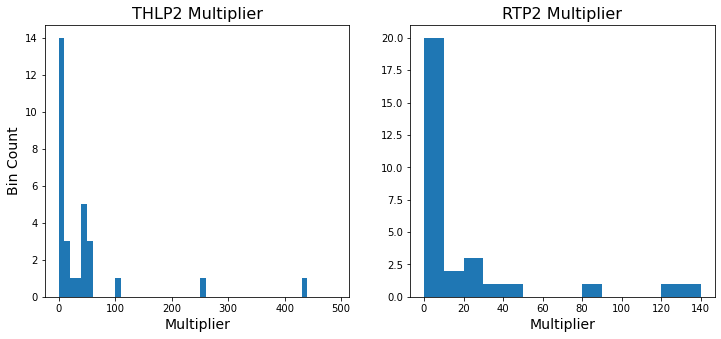

In [57]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

binsTHL2 = np.arange(0,500,10)
binsQV2  = np.arange(0,150,10)

axs[0].hist(SCAMmultiplier_thl2_match, bins=binsTHL2)
axs[1].hist(SCAMmultiplier_qv2_match, bins=binsQV2)

axs[0].set_title('THLP2 Multiplier',fontsize=16)
axs[1].set_title('RTP2 Multiplier',fontsize=16)

axs[0].set_xlabel('Multiplier',fontsize=14)
axs[1].set_xlabel('Multiplier',fontsize=14)
axs[0].set_ylabel('Bin Count', fontsize=14)


(17318.0, 17410.0)

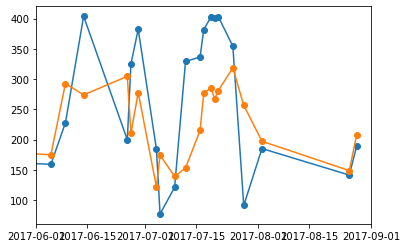

In [26]:
plt.plot(matchDays_default, np.squeeze(hmgSCAM_maxSH), '-o' )
plt.plot(matchDays_default, hmgLES_maxSH, '-o' )
plt.xlim([datetime.datetime(2017,6,1), datetime.datetime(2017,9,1)])

(0.0, 13.0)

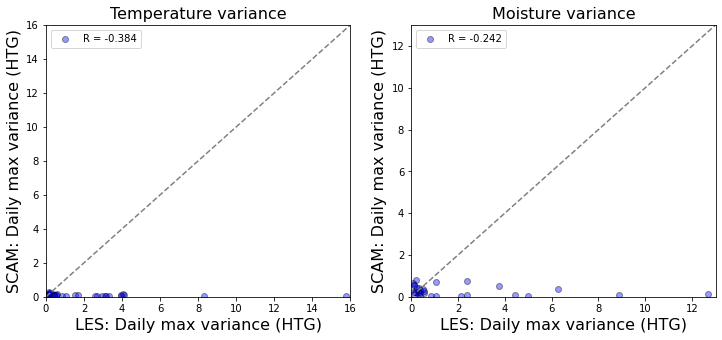

In [55]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

xLabel = 'LES: Daily max variance (HTG)'

axs[0].plot(dailymax_LES_thl2_match,      np.squeeze(dailyMax_SCAMhtg_thlp2_match), 'bo',alpha=0.4, markeredgecolor='k')
axs[1].plot((dailymax_LES_qv2_match*1e6), np.squeeze(dailyMax_SCAMhtg_rtp2_match), 'bo',alpha=0.4, markeredgecolor='k')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM: Daily max variance (HTG)',fontsize=16)
axs[1].set_ylabel('SCAM: Daily max variance (HTG)',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(dailymax_LES_thl2_match,      np.squeeze(dailyMax_SCAMhtg_thlp2_match))[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef((dailymax_LES_qv2_match*1e6), np.squeeze(dailyMax_SCAMhtg_rtp2_match))[0,1])])

axs[0].plot(np.arange(0,17,0.5), np.arange(0,17,0.5), '--', color='grey')
axs[1].plot(np.arange(0,16,0.5), np.arange(0,16,0.5), '--', color='grey')

axs[0].set_ylim([0.0, 16])
axs[0].set_xlim([0.0, 16])

axs[1].set_ylim([0.0, 13])
axs[1].set_xlim([0.0, 13])



In [ ]:
rtp2_dayMaxAllLevs

(0.0, 1.6e-05)

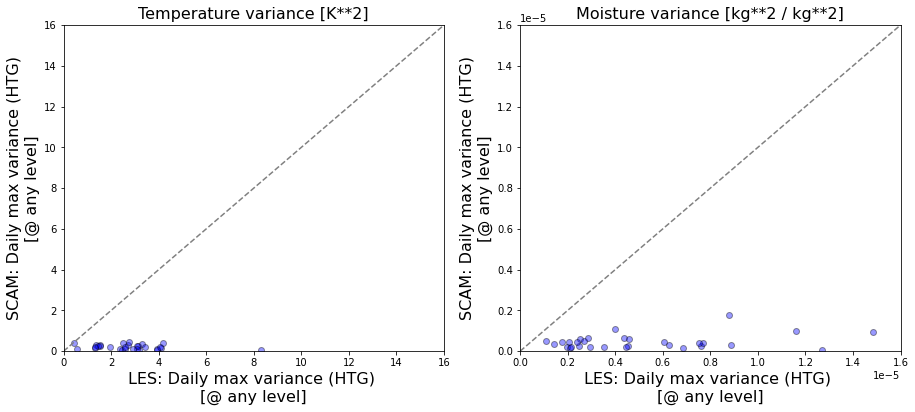

In [35]:
fig,axs = plt.subplots(1,2, figsize=(15,6))
axs     = axs.ravel()

xLabel = 'LES: Daily max variance (HTG) \n[@ any level]'

axs[0].plot(thl2_dayMaxAllLevs,      np.squeeze(thlp2_dayMaxAllLevs), 'bo',alpha=0.4, markeredgecolor='k')
axs[1].plot((qv2_dayMaxAllLevs), np.squeeze(rtp2_dayMaxAllLevs)*1e-6, 'bo',alpha=0.4, markeredgecolor='k')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM: Daily max variance (HTG)\n[@ any level]',fontsize=16)
axs[1].set_ylabel('SCAM: Daily max variance (HTG)\n[@ any level]',fontsize=16)

axs[0].set_title('Temperature variance [K**2]',fontsize=16)
axs[1].set_title('Moisture variance [kg**2 / kg**2]',fontsize=16)

# axs[0].legend(['R = % .3f' % (np.corrcoef(thl2_dayMaxAllLevs,      np.squeeze(thlp2_dayMaxAllLevs))[0,1])])
# axs[1].legend(['R = % .3f' % (np.corrcoef((qv2_dayMaxAllLevs), np.squeeze(rtp2_dayMaxAllLevs)*1e-6)[0,1])])

axs[0].plot(np.arange(0,17,0.5), np.arange(0,17,0.5), '--', color='grey')
axs[1].plot(np.arange(0,1.8e-5,0.1e-5), np.arange(0,1.8e-5,0.1e-5), '--', color='grey')

axs[0].set_ylim([0.0, 16])
axs[0].set_xlim([0.0, 16])

axs[1].set_ylim([0.0, 1.6e-5])
axs[1].set_xlim([0.0, 1.6e-5])



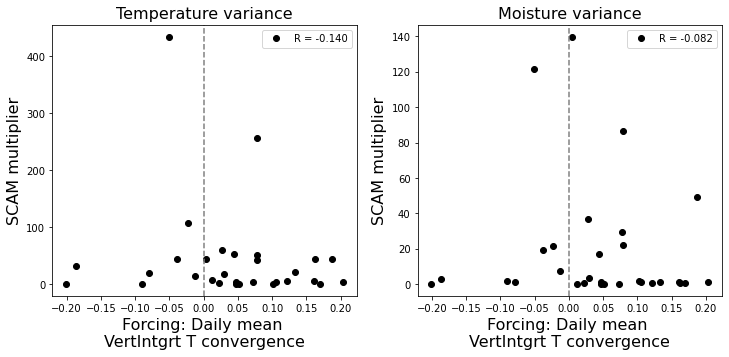

In [32]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

axs[0].plot(daymean_Tconvg.values, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(daymean_Tconvg.values, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel('Forcing: Daily mean \nVertIntgrt T convergence',fontsize=16)
axs[1].set_xlabel('Forcing: Daily mean \nVertIntgrt T convergence',fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(daymean_Tconvg, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(daymean_Tconvg, SCAMmultiplier_qv2_match)[0,1])])

axs[0].axvline(0, color='gray', linestyle='--')
axs[1].axvline(0, color='gray', linestyle='--')


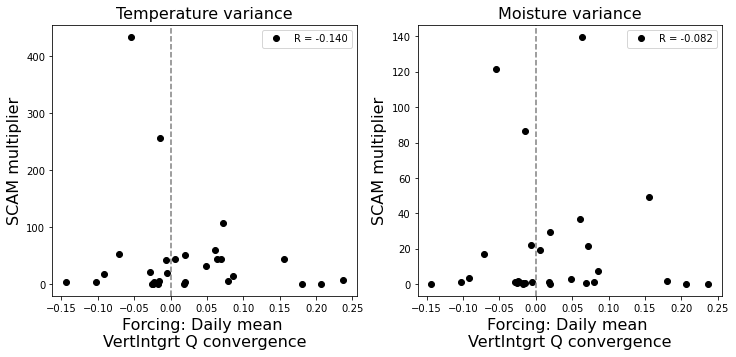

In [31]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

axs[0].plot(daymean_Qconvg.values, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(daymean_Qconvg.values, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel('Forcing: Daily mean \nVertIntgrt Q convergence',fontsize=16)
axs[1].set_xlabel('Forcing: Daily mean \nVertIntgrt Q convergence',fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(daymean_Tconvg, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(daymean_Tconvg, SCAMmultiplier_qv2_match)[0,1])])

axs[0].axvline(0, color='gray', linestyle='--')
axs[1].axvline(0, color='gray', linestyle='--')


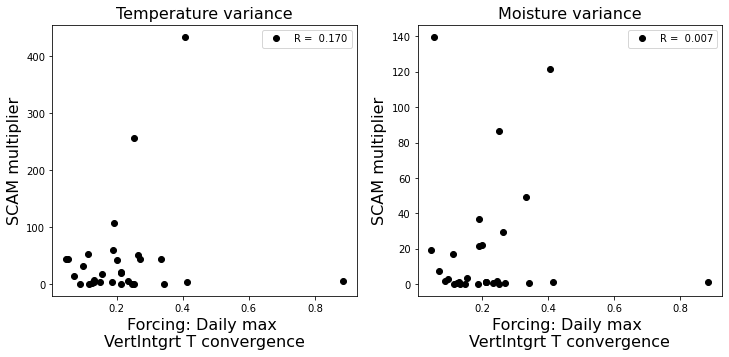

In [71]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

axs[0].plot(daymax_Tconvg.values, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(daymax_Tconvg.values, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel('Forcing: Daily max \nVertIntgrt T convergence',fontsize=16)
axs[1].set_xlabel('Forcing: Daily max \nVertIntgrt T convergence',fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(daymax_Tconvg, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(daymax_Tconvg, SCAMmultiplier_qv2_match)[0,1])])

# axs[0].axvline(0, color='gray', linestyle='--')
# axs[1].axvline(0, color='gray', linestyle='--')


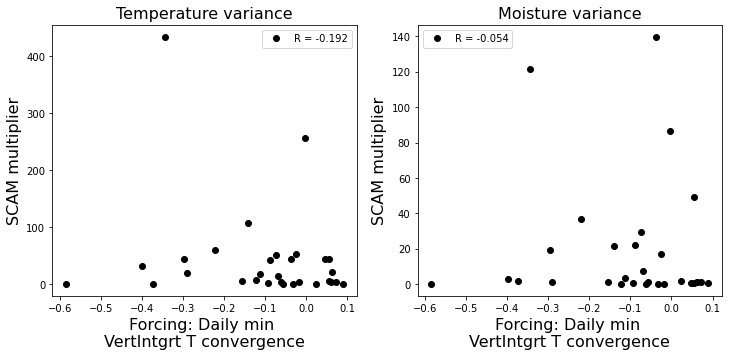

In [74]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

axs[0].plot(daymin_Tconvg.values, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(daymin_Tconvg.values, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel('Forcing: Daily min \nVertIntgrt T convergence',fontsize=16)
axs[1].set_xlabel('Forcing: Daily min \nVertIntgrt T convergence',fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(daymin_Tconvg, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(daymin_Tconvg, SCAMmultiplier_qv2_match)[0,1])])

# axs[0].axvline(0, color='gray', linestyle='--')
# axs[1].axvline(0, color='gray', linestyle='--')


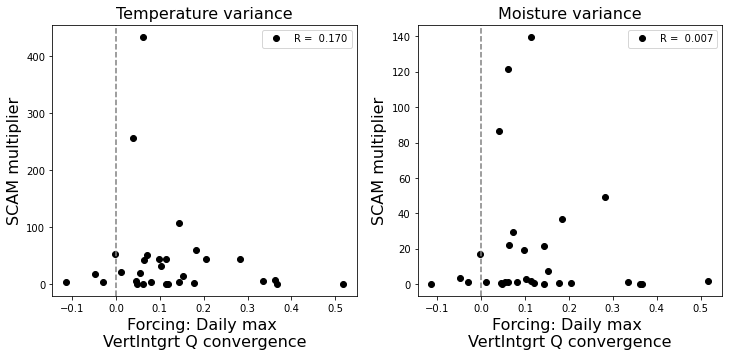

In [75]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

axs[0].plot(daymax_Qconvg.values, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(daymax_Qconvg.values, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel('Forcing: Daily max \nVertIntgrt Q convergence',fontsize=16)
axs[1].set_xlabel('Forcing: Daily max \nVertIntgrt Q convergence',fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(daymax_Tconvg, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(daymax_Tconvg, SCAMmultiplier_qv2_match)[0,1])])

axs[0].axvline(0, color='gray', linestyle='--')
axs[1].axvline(0, color='gray', linestyle='--')


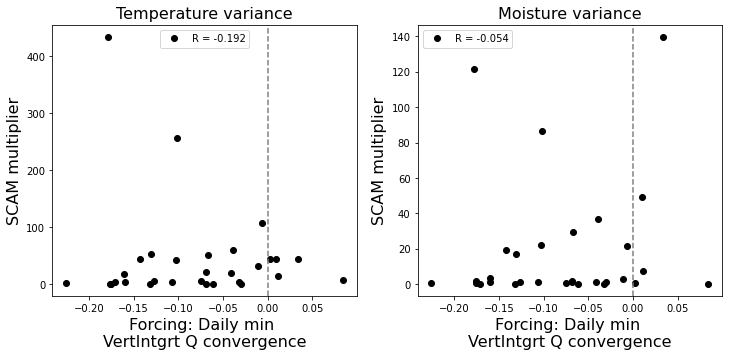

In [76]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

axs[0].plot(daymin_Qconvg.values, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(daymin_Qconvg.values, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel('Forcing: Daily min \nVertIntgrt Q convergence',fontsize=16)
axs[1].set_xlabel('Forcing: Daily min \nVertIntgrt Q convergence',fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(daymin_Tconvg, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(daymin_Tconvg, SCAMmultiplier_qv2_match)[0,1])])

axs[0].axvline(0, color='gray', linestyle='--')
axs[1].axvline(0, color='gray', linestyle='--')


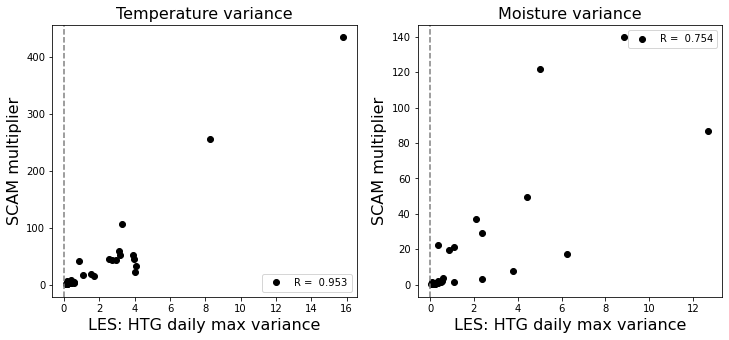

In [58]:
# fig,axs = plt.subplots(1,2, figsize=(12,5))
# axs     = axs.ravel()

# axs[0].plot(dailymax_LES_thl2_match, SCAMmultiplier_thl2_match, 'ko')
# axs[1].plot((dailymax_LES_qv2_match*1e6), SCAMmultiplier_qv2_match, 'ko')

# axs[0].set_xlabel('LES: HTG daily max variance',fontsize=16)
# axs[1].set_xlabel('LES: HTG daily max variance',fontsize=16)

# axs[0].set_ylabel('SCAM multiplier',fontsize=16)
# axs[1].set_ylabel('SCAM multiplier',fontsize=16)

# axs[0].set_title('Temperature variance',fontsize=16)
# axs[1].set_title('Moisture variance',fontsize=16)

# axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
# axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])

# axs[0].axvline(0, color='gray', linestyle='--')
# axs[1].axvline(0, color='gray', linestyle='--')


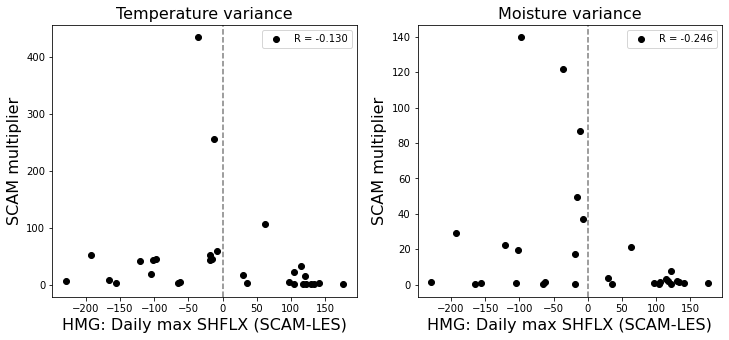

In [28]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

xVar   = np.squeeze(hmgSCAM_maxSH.values) - hmgLES_maxSH.values
xLabel = 'HMG: Daily max SHFLX (SCAM-LES)'

axs[0].plot(xVar, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])

axs[0].axvline(0, color='gray', linestyle='--')
axs[1].axvline(0, color='gray', linestyle='--')


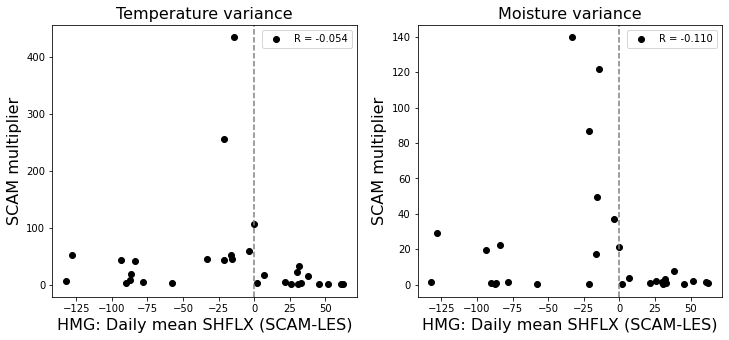

In [30]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

xVar   = np.squeeze(hmgSCAM_meanSH.values) - hmgLES_meanSH.values
xLabel = 'HMG: Daily mean SHFLX (SCAM-LES)'

axs[0].plot(xVar, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])

axs[0].axvline(0, color='gray', linestyle='--')
axs[1].axvline(0, color='gray', linestyle='--')


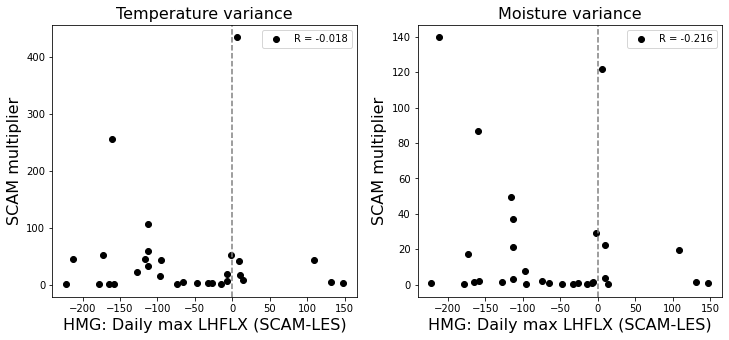

In [32]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

xVar   = np.squeeze(hmgSCAM_maxLH.values) - hmgLES_maxLH.values
xLabel = 'HMG: Daily max LHFLX (SCAM-LES)'

axs[0].plot(xVar, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])

axs[0].axvline(0, color='gray', linestyle='--')
axs[1].axvline(0, color='gray', linestyle='--')


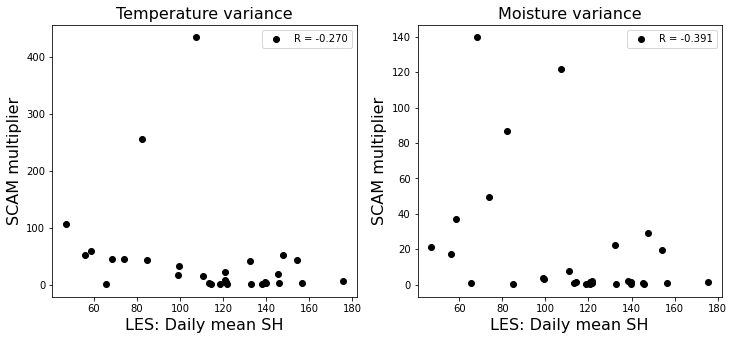

In [33]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

# xVar   = np.squeeze(hmgSCAM_maxEF.values) - hmgLES_maxEF.values
xVar   = htgLES_meanSH.values
xLabel = 'LES: Daily mean SH'

axs[0].plot(xVar, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])



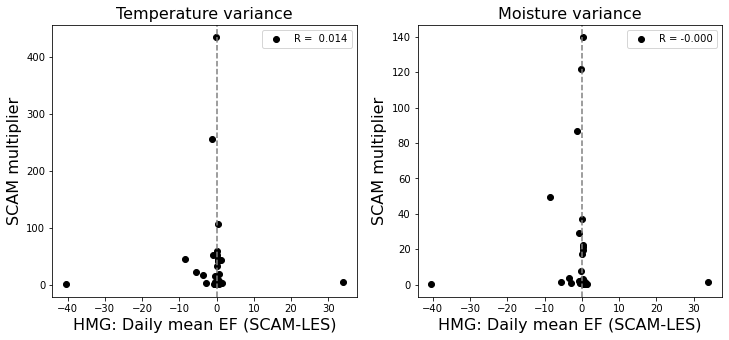

In [36]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

xVar   = np.squeeze(hmgSCAM_meanEF.values) - hmgLES_meanEF.values
xLabel = 'HMG: Daily mean EF (SCAM-LES)'

axs[0].plot(xVar, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])

axs[0].axvline(0, color='gray', linestyle='--')
axs[1].axvline(0, color='gray', linestyle='--')


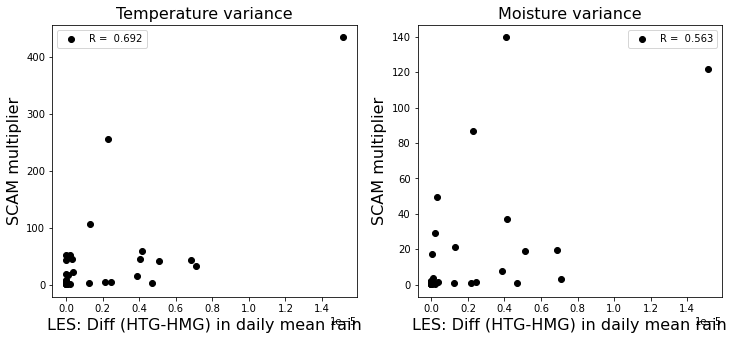

In [82]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

# xVar   = np.squeeze(hmgSCAM_maxEF.values) - hmgLES_maxEF.values
xVar   = htgLES_meanRAIN.values - hmgLES_meanRAIN.values
xLabel = 'LES: Diff (HTG-HMG) in daily mean rain'

axs[0].plot(xVar, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])



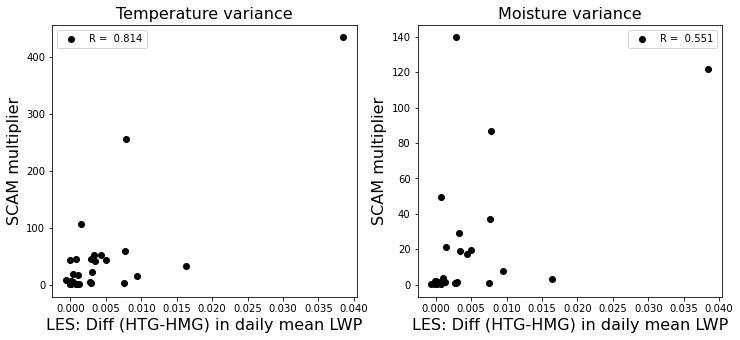

In [85]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

# xVar   = np.squeeze(hmgSCAM_maxEF.values) - hmgLES_maxEF.values
xVar   = htgLES_meanLWP.values - hmgLES_meanLWP.values
xLabel = 'LES: Diff (HTG-HMG) in daily mean LWP'

axs[0].plot(xVar, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])



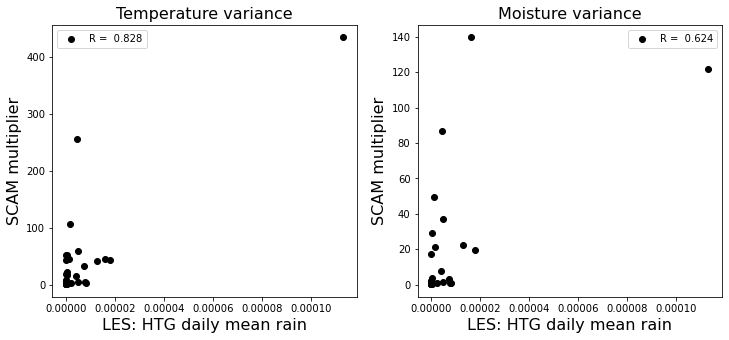

In [40]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

# xVar   = np.squeeze(hmgSCAM_maxEF.values) - hmgLES_maxEF.values
xVar   = htgLES_meanRAIN.values
xLabel = 'LES: HTG daily mean rain'

axs[0].plot(xVar, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])

# axs[0].set_xlim([0.0, 0.000025])
# axs[1].set_xlim([0.0, 0.000025])
# axs[0].set_ylim([0.0, 100])
# axs[1].set_ylim([0.0, 60])


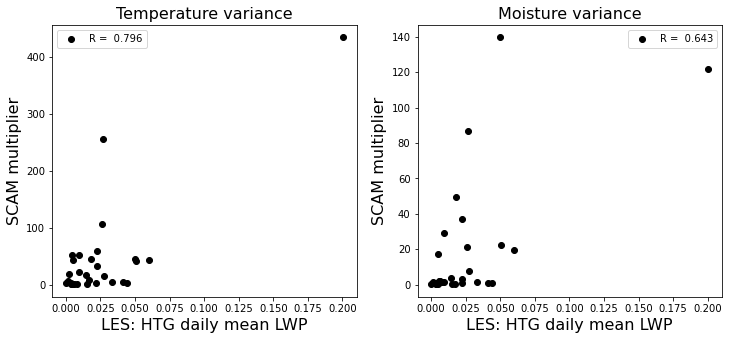

In [41]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

# xVar   = np.squeeze(hmgSCAM_maxEF.values) - hmgLES_maxEF.values
xVar   = htgLES_meanLWP.values
xLabel = 'LES: HTG daily mean LWP'

axs[0].plot(xVar, SCAMmultiplier_thl2_match, 'ko')
axs[1].plot(xVar, SCAMmultiplier_qv2_match, 'ko')

axs[0].set_xlabel(xLabel,fontsize=16)
axs[1].set_xlabel(xLabel,fontsize=16)

axs[0].set_ylabel('SCAM multiplier',fontsize=16)
axs[1].set_ylabel('SCAM multiplier',fontsize=16)

axs[0].set_title('Temperature variance',fontsize=16)
axs[1].set_title('Moisture variance',fontsize=16)

axs[0].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_thl2_match)[0,1])])
axs[1].legend(['R = % .3f' % (np.corrcoef(xVar, SCAMmultiplier_qv2_match)[0,1])])

# axs[0].set_xlim([0.0, 0.000025])
# axs[1].set_xlim([0.0, 0.000025])
# axs[0].set_ylim([0.0, 100])
# axs[1].set_ylim([0.0, 60])


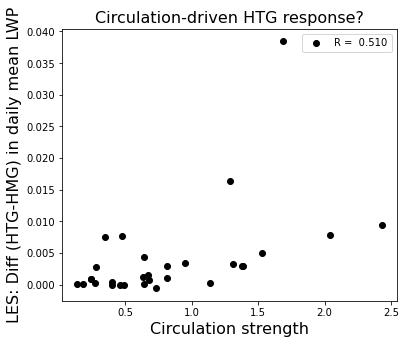

In [87]:
fig,axs = plt.subplots(1,1, figsize=(6,5))

# xVar   = np.squeeze(hmgSCAM_maxEF.values) - hmgLES_maxEF.values
yVar   = htgLES_meanLWP.values - hmgLES_meanLWP.values
yLabel = 'LES: Diff (HTG-HMG) in daily mean LWP'

xVar   = circMetric_daysUsed_defMatch
xLabel = 'Circulation strength'

axs.plot(xVar, yVar, 'ko')

axs.set_xlabel(xLabel,fontsize=16)
axs.set_ylabel(yLabel,fontsize=16)

axs.set_title('Circulation-driven HTG response?',fontsize=16)

axs.legend(['R = % .3f' % (np.corrcoef(xVar, yVar)[0,1])])



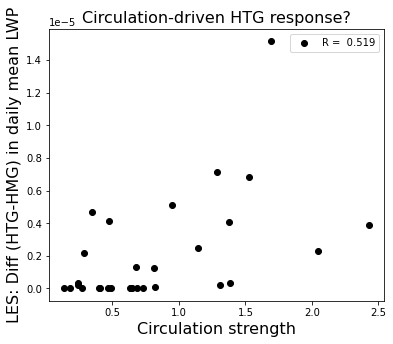

In [88]:
fig,axs = plt.subplots(1,1, figsize=(6,5))

# xVar   = np.squeeze(hmgSCAM_maxEF.values) - hmgLES_maxEF.values
yVar   = htgLES_meanRAIN.values - hmgLES_meanRAIN.values
yLabel = 'LES: Diff (HTG-HMG) in daily mean LWP'

xVar   = circMetric_daysUsed_defMatch
xLabel = 'Circulation strength'

axs.plot(xVar, yVar, 'ko')

axs.set_xlabel(xLabel,fontsize=16)
axs.set_ylabel(yLabel,fontsize=16)

axs.set_title('Circulation-driven HTG response?',fontsize=16)

axs.legend(['R = % .3f' % (np.corrcoef(xVar, yVar)[0,1])])



**Are the relationships between variables at least similar in SCAM and LES?**

LES covariance: -31.669
SCAM covariance: 2.370


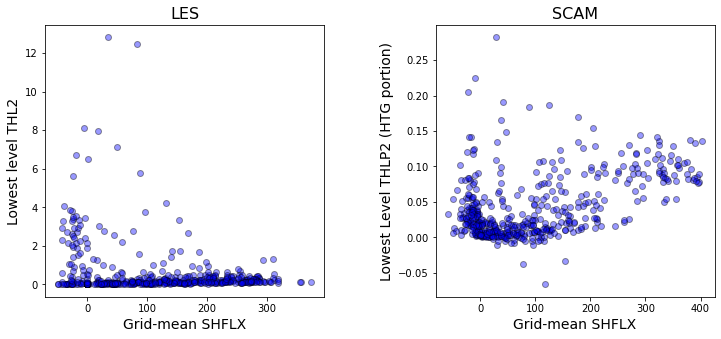

In [110]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace = 0.4)

## Plot LES relationship
xvarLES = LESdefault_allDays['SHgrid'].sel(case='HTG').values
yvarLES = LES_allDays_thl2_matchDefault.sel(case='HTG').resample(time='1H').mean().dropna(dim='time').values
xLabel  = 'Grid-mean SHFLX'
yLabel  = 'Lowest level THL2'

axs[0].plot(np.squeeze(xvarLES), np.squeeze(yvarLES), 'bo', alpha=0.4, markeredgecolor='k')
axs[0].set_ylabel(yLabel, fontsize=14)
axs[0].set_xlabel(xLabel, fontsize=14)
axs[0].set_title('LES', fontsize=16)

print('LES covariance: %.3f' % (np.cov( np.squeeze(xvarLES), np.squeeze(yvarLES) , bias=True)[0][1]) )


## Plot SCAM relationship
# xvarSCAM = SCAM_matchDefaultLES.sel(case='HTG*01').EF.values
xvarSCAM = SCAM_matchDefaultLES.sel(case='HTG*01').SHFLX.resample(time='1H').mean().dropna(dim='time').values
yvarSCAM = SCAM_thl2_htgPart.resample(time='1H').mean().dropna(dim='time').values
xLabel   = 'Grid-mean SHFLX'
yLabel   = 'Lowest Level THLP2 (HTG portion)'

axs[1].plot(np.squeeze(xvarSCAM), np.squeeze(yvarSCAM), 'bo', alpha=0.4, markeredgecolor='k')
axs[1].set_ylabel(yLabel, fontsize=14)
axs[1].set_xlabel(xLabel, fontsize=14)
axs[1].set_title('SCAM', fontsize=16)

print('SCAM covariance: %.3f' % (np.cov( np.squeeze(xvarSCAM), np.squeeze(yvarSCAM) , bias=True)[0][1]) )



LES covariance: -8.675
SCAM covariance: 0.029


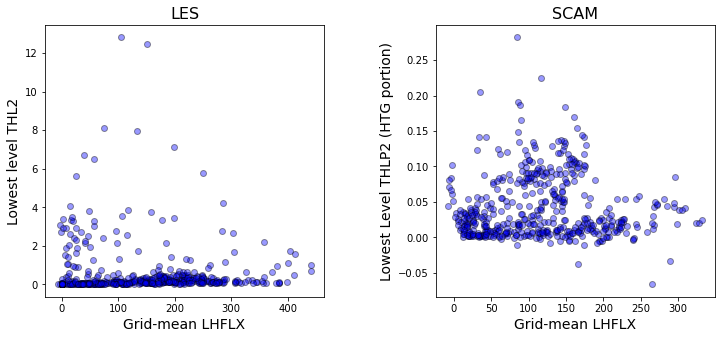

In [109]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace = 0.4)

## Plot LES relationship
xvarLES = LESdefault_allDays['LHgrid'].sel(case='HTG').values
yvarLES = LES_allDays_thl2_matchDefault.sel(case='HTG').resample(time='1H').mean().dropna(dim='time').values
xLabel  = 'Grid-mean LHFLX'
yLabel  = 'Lowest level THL2'

axs[0].plot(np.squeeze(xvarLES), np.squeeze(yvarLES), 'bo', alpha=0.4, markeredgecolor='k')
axs[0].set_ylabel(yLabel, fontsize=14)
axs[0].set_xlabel(xLabel, fontsize=14)
axs[0].set_title('LES', fontsize=16)

print('LES covariance: %.3f' % (np.cov( np.squeeze(xvarLES), np.squeeze(yvarLES) , bias=True)[0][1]) )


## Plot SCAM relationship
xvarSCAM = SCAM_matchDefaultLES.sel(case='HTG*01').LHFLX.resample(time='1H').mean().dropna(dim='time').values
yvarSCAM = SCAM_thl2_htgPart.resample(time='1H').mean().dropna(dim='time').values
xLabel   = 'Grid-mean LHFLX'
yLabel   = 'Lowest Level THLP2 (HTG portion)'

axs[1].plot(np.squeeze(xvarSCAM), np.squeeze(yvarSCAM), 'bo', alpha=0.4, markeredgecolor='k')
axs[1].set_ylabel(yLabel, fontsize=14)
axs[1].set_xlabel(xLabel, fontsize=14)
axs[1].set_title('SCAM', fontsize=16)

print('SCAM covariance: %.3f' % (np.cov( np.squeeze(xvarSCAM), np.squeeze(yvarSCAM) , bias=True)[0][1]) )


LES covariance: -26.365
SCAM covariance: 3.185


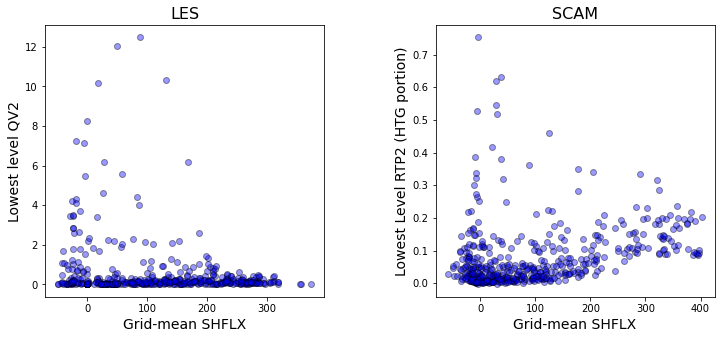

In [111]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace = 0.4)

## Plot LES relationship
xvarLES = LESdefault_allDays['SHgrid'].sel(case='HTG').values
yvarLES = LES_allDays_qv2_matchDefault.sel(case='HTG').resample(time='1H').mean().dropna(dim='time').values * 1e6
xLabel  = 'Grid-mean SHFLX'
yLabel  = 'Lowest level QV2'

axs[0].plot(np.squeeze(xvarLES), np.squeeze(yvarLES), 'bo', alpha=0.4, markeredgecolor='k')
axs[0].set_ylabel(yLabel, fontsize=14)
axs[0].set_xlabel(xLabel, fontsize=14)
axs[0].set_title('LES', fontsize=16)

print('LES covariance: %.3f' % (np.cov( np.squeeze(xvarLES), np.squeeze(yvarLES) , bias=True)[0][1]) )


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Plot SCAM relationship
xvarSCAM = SCAM_matchDefaultLES.sel(case='HTG*01').SHFLX.resample(time='1H').mean().dropna(dim='time').values
yvarSCAM = SCAM_rtp2_htgPart.resample(time='1H').mean().dropna(dim='time').values
xLabel   = 'Grid-mean SHFLX'
yLabel   = 'Lowest Level RTP2 (HTG portion)'

axs[1].plot(np.squeeze(xvarSCAM), np.squeeze(yvarSCAM), 'bo', alpha=0.4, markeredgecolor='k')
axs[1].set_ylabel(yLabel, fontsize=14)
axs[1].set_xlabel(xLabel, fontsize=14)
axs[1].set_title('SCAM', fontsize=16)

print('SCAM covariance: %.3f' % (np.cov( np.squeeze(xvarSCAM), np.squeeze(yvarSCAM) , bias=True)[0][1]) )



LES covariance: 14.259
SCAM covariance: 0.707


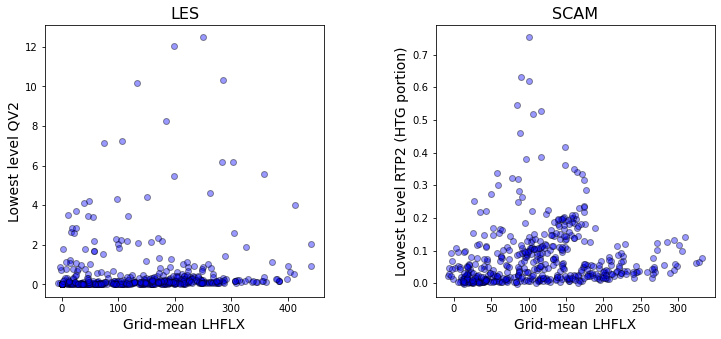

In [112]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace = 0.4)

## Plot LES relationship
xvarLES = LESdefault_allDays['LHgrid'].sel(case='HTG').values
yvarLES = LES_allDays_qv2_matchDefault.sel(case='HTG').resample(time='1H').mean().dropna(dim='time').values * 1e6
xLabel  = 'Grid-mean LHFLX'
yLabel  = 'Lowest level QV2'

axs[0].plot(np.squeeze(xvarLES), np.squeeze(yvarLES), 'bo', alpha=0.4, markeredgecolor='k')
axs[0].set_ylabel(yLabel, fontsize=14)
axs[0].set_xlabel(xLabel, fontsize=14)
axs[0].set_title('LES', fontsize=16)

print('LES covariance: %.3f' % (np.cov( np.squeeze(xvarLES), np.squeeze(yvarLES) , bias=True)[0][1]) )


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Plot SCAM relationship
xvarSCAM = SCAM_matchDefaultLES.sel(case='HTG*01').LHFLX.resample(time='1H').mean().dropna(dim='time').values
yvarSCAM = SCAM_rtp2_htgPart.resample(time='1H').mean().dropna(dim='time').values
xLabel   = 'Grid-mean LHFLX'
yLabel   = 'Lowest Level RTP2 (HTG portion)'

axs[1].plot(np.squeeze(xvarSCAM), np.squeeze(yvarSCAM), 'bo', alpha=0.4, markeredgecolor='k')
axs[1].set_ylabel(yLabel, fontsize=14)
axs[1].set_xlabel(xLabel, fontsize=14)
axs[1].set_title('SCAM', fontsize=16)

print('SCAM covariance: %.3f' % (np.cov( np.squeeze(xvarSCAM), np.squeeze(yvarSCAM) , bias=True)[0][1]) )



LES covariance: 0.010
SCAM covariance: -0.002


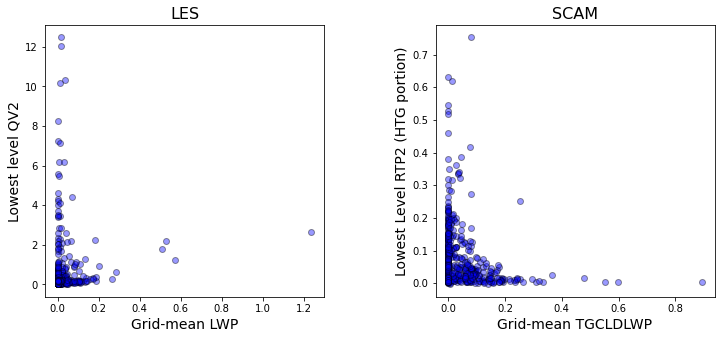

In [113]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace = 0.4)

## Plot LES relationship
xvarLES = LESdefault_allDays['LWPgrid'].sel(case='HTG').values
yvarLES = LES_allDays_qv2_matchDefault.sel(case='HTG').resample(time='1H').mean().dropna(dim='time').values * 1e6
xLabel  = 'Grid-mean LWP'
yLabel  = 'Lowest level QV2'

axs[0].plot(np.squeeze(xvarLES), np.squeeze(yvarLES), 'bo', alpha=0.4, markeredgecolor='k')
axs[0].set_ylabel(yLabel, fontsize=14)
axs[0].set_xlabel(xLabel, fontsize=14)
axs[0].set_title('LES', fontsize=16)

print('LES covariance: %.3f' % (np.cov( np.squeeze(xvarLES), np.squeeze(yvarLES) , bias=True)[0][1]) )


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Plot SCAM relationship
xvarSCAM = SCAM_matchDefaultLES.sel(case='HTG*01').TGCLDLWP.resample(time='1H').mean().dropna(dim='time').values
yvarSCAM = SCAM_rtp2_htgPart.resample(time='1H').mean().dropna(dim='time').values
xLabel   = 'Grid-mean TGCLDLWP'
yLabel   = 'Lowest Level RTP2 (HTG portion)'

axs[1].plot(np.squeeze(xvarSCAM), np.squeeze(yvarSCAM), 'bo', alpha=0.4, markeredgecolor='k')
axs[1].set_ylabel(yLabel, fontsize=14)
axs[1].set_xlabel(xLabel, fontsize=14)
axs[1].set_title('SCAM', fontsize=16)

print('SCAM covariance: %.3f' % (np.cov( np.squeeze(xvarSCAM), np.squeeze(yvarSCAM) , bias=True)[0][1]) )



LES covariance: 0.026
SCAM covariance: -0.001


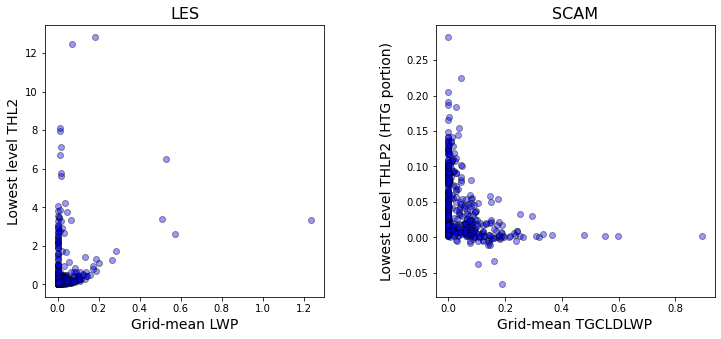

In [114]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace = 0.4)

## Plot LES relationship
xvarLES = LESdefault_allDays['LWPgrid'].sel(case='HTG').values
yvarLES = LES_allDays_thl2_matchDefault.sel(case='HTG').resample(time='1H').mean().dropna(dim='time').values 
xLabel  = 'Grid-mean LWP'
yLabel  = 'Lowest level THL2'

axs[0].plot(np.squeeze(xvarLES), np.squeeze(yvarLES), 'bo', alpha=0.4, markeredgecolor='k')
axs[0].set_ylabel(yLabel, fontsize=14)
axs[0].set_xlabel(xLabel, fontsize=14)
axs[0].set_title('LES', fontsize=16)

print('LES covariance: %.3f' % (np.cov( np.squeeze(xvarLES), np.squeeze(yvarLES) , bias=True)[0][1]) )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Plot SCAM relationship
xvarSCAM = SCAM_matchDefaultLES.sel(case='HTG*01').TGCLDLWP.resample(time='1H').mean().dropna(dim='time').values
yvarSCAM = SCAM_thl2_htgPart.resample(time='1H').mean().dropna(dim='time').values
xLabel   = 'Grid-mean TGCLDLWP'
yLabel   = 'Lowest Level THLP2 (HTG portion)'

axs[1].plot(np.squeeze(xvarSCAM), np.squeeze(yvarSCAM), 'bo', alpha=0.4, markeredgecolor='k')
axs[1].set_ylabel(yLabel, fontsize=14)
axs[1].set_xlabel(xLabel, fontsize=14)
axs[1].set_title('SCAM', fontsize=16)

print('SCAM covariance: %.3f' % (np.cov( np.squeeze(xvarSCAM), np.squeeze(yvarSCAM) , bias=True)[0][1]) )



### Plots to show the SCAM simulations

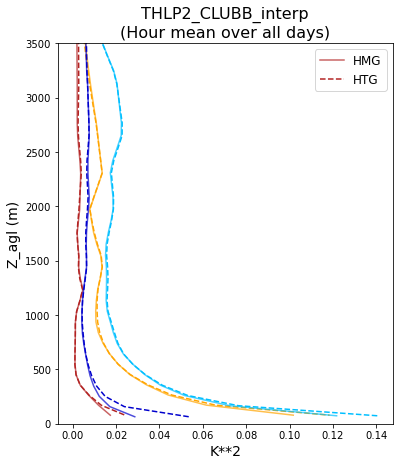

In [37]:
## Choose hours to plot and get mean 

varName = 'THLP2_CLUBB_interp'
levName = 'Z3_interp'
ymin    = 0
ymax    = 3500

hourSel    = [  9,          12,            15,             18]
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (SCAM_matchDefaultLES["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = SCAM_matchDefaultLES.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    
    if iHr==0:
        axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values), alpha=0.7, color=colorsList[iHr], label='HMG' )
        axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',      color=colorsList[iHr], label='HTG' )
    else:
        axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values), alpha=0.7, color=colorsList[iHr]  )
        axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',      color=colorsList[iHr] )
        
    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title(varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('K**2', fontsize=14)
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])



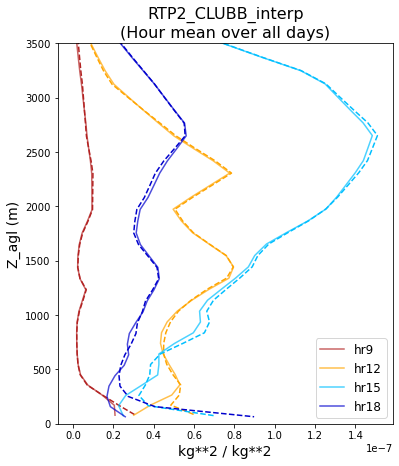

In [38]:
## Choose hours to plot and get mean 

varName = 'RTP2_CLUBB_interp'
levName = 'Z3_interp'
ymin    = 0
ymax    = 3500

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (SCAM_matchDefaultLES["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = SCAM_matchDefaultLES.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    
    axs.plot( np.squeeze(HMGvar[varName].values)*1e-6, np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values)*1e-6, np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title(varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('kg**2 / kg**2', fontsize=14)
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


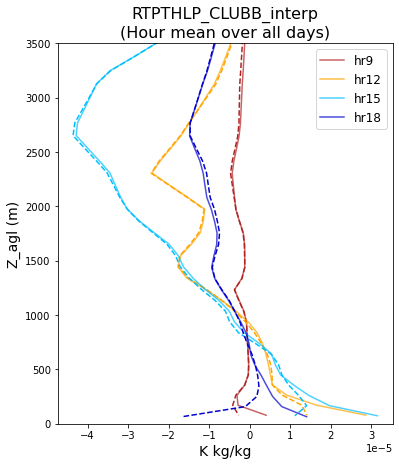

In [39]:
## Choose hours to plot and get mean 

varName = 'RTPTHLP_CLUBB_interp'
levName = 'Z3_interp'
ymin    = 0
ymax    = 3500

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (SCAM_matchDefaultLES["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = SCAM_matchDefaultLES.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    
    axs.plot( np.squeeze(HMGvar[varName].values)*1e-3, np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values)*1e-3, np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title(varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('K kg/kg', fontsize=14)
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


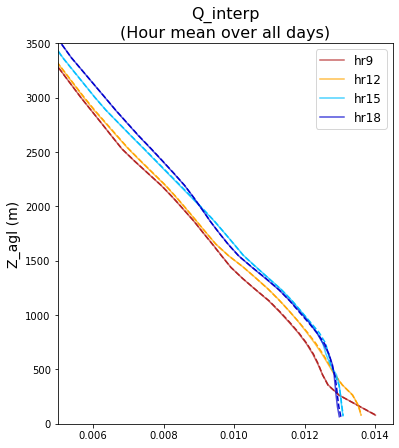

In [40]:
## Choose hours to plot and get mean 

varName = 'Q_interp'
levName = 'Z3_interp'
ymin    = 0
ymax    = 3500

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (SCAM_matchDefaultLES["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = SCAM_matchDefaultLES.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title(varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    
    axs.set_xlim([0.005, 0.0145])
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


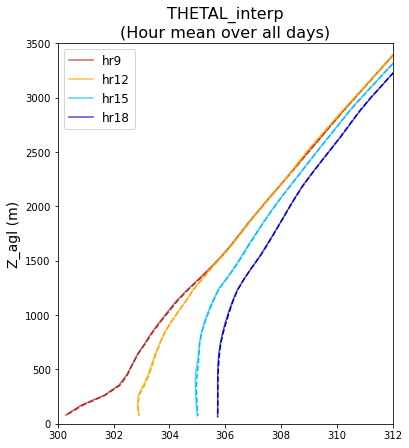

In [55]:
## Choose hours to plot and get mean 

varName = 'THETAL_interp'
levName = 'Z3_interp'
ymin    = 0
ymax    = 3500

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (SCAM_matchDefaultLES["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = SCAM_matchDefaultLES.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title(varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    
    axs.set_xlim([300, 312])
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


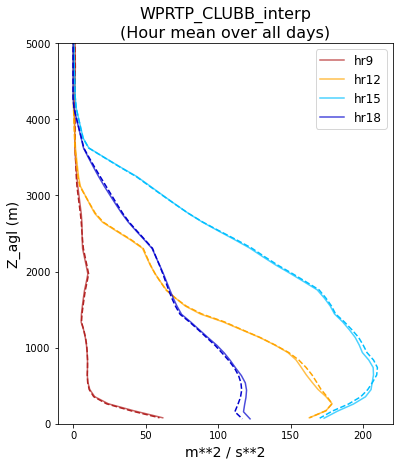

In [41]:
## Choose hours to plot and get mean 

varName = 'WPRTP_CLUBB_interp'
levName = 'Z3_interp'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (SCAM_matchDefaultLES["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = SCAM_matchDefaultLES.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title(varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('m**2 / s**2', fontsize=14)

    # axs.set_xlim([0.006, 0.0145])
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


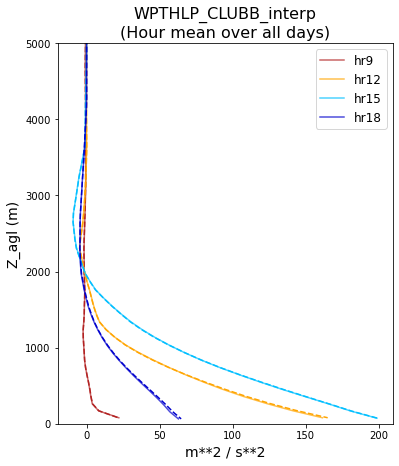

In [56]:
## Choose hours to plot and get mean 

varName = 'WPTHLP_CLUBB_interp'
levName = 'Z3_interp'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (SCAM_matchDefaultLES["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = SCAM_matchDefaultLES.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title(varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('m**2 / s**2', fontsize=14)

    # axs.set_xlim([0.006, 0.0145])
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


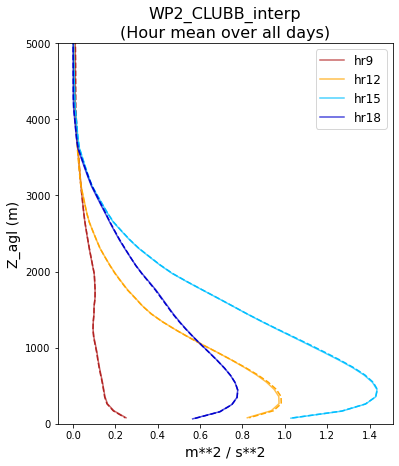

In [57]:
## Choose hours to plot and get mean 

varName = 'WP2_CLUBB_interp'
levName = 'Z3_interp'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (SCAM_matchDefaultLES["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = SCAM_matchDefaultLES.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title(varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('m**2 / s**2', fontsize=14)

    # axs.set_xlim([0.006, 0.0145])
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


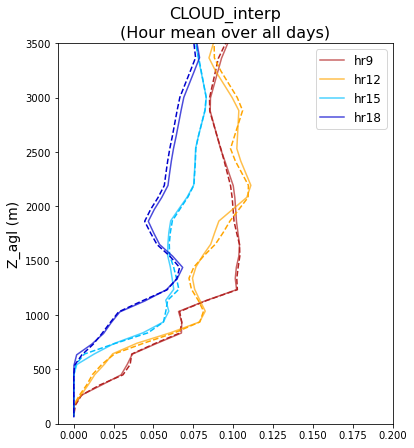

In [42]:
## Choose hours to plot and get mean 

varName = 'CLOUD_interp'
levName = 'Z3_interp'
ymin    = 0
ymax    = 3500

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (SCAM_matchDefaultLES["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = SCAM_matchDefaultLES.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title(varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    
    axs.set_xlim([-0.01,0.2])
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


### Plots to show the LES simulations

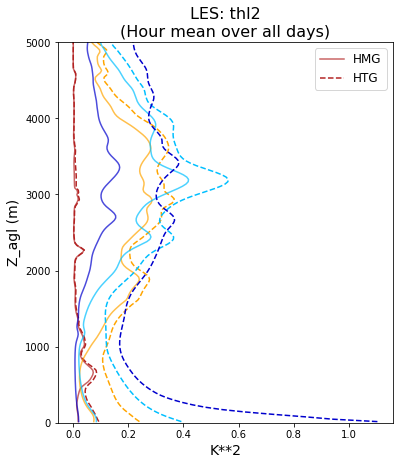

In [43]:
## Choose hours to plot and get mean 

varName = 'thl2'
levName = 'z'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']

colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (LES_allDays_allVars_matchDefault["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = LES_allDays_allVars_matchDefault.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG')
    
    if iHr==0:
        axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values), alpha=0.7, color=colorsList[iHr], label='HMG' )
        axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',      color=colorsList[iHr], label='HTG' )
    else:
        axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values), alpha=0.7, color=colorsList[iHr]  )
        axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',      color=colorsList[iHr] )
        
    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title('LES: '+varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('K**2', fontsize=14)
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])



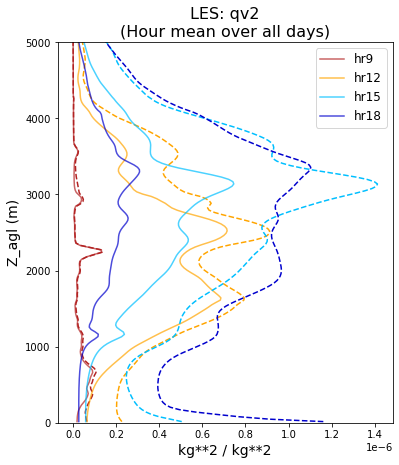

In [44]:
## Choose hours to plot and get mean 

varName = 'qv2'
levName = 'z'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (LES_allDays_allVars_matchDefault["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = LES_allDays_allVars_matchDefault.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title('LES: '+varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('kg**2 / kg**2', fontsize=14)
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


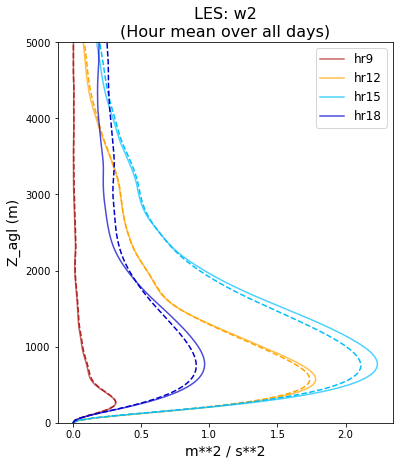

In [45]:
## Choose hours to plot and get mean 

varName = 'w2'
levName = 'zw'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (LES_allDays_allVars_matchDefault["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = LES_allDays_allVars_matchDefault.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title('LES: '+varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('m**2 / s**2', fontsize=14)
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


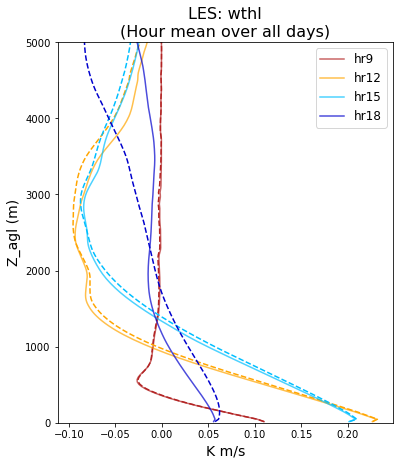

In [46]:
## Choose hours to plot and get mean 

varName = 'wthl'
levName = 'z'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (LES_allDays_allVars_matchDefault["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = LES_allDays_allVars_matchDefault.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title('LES: '+varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('K m/s', fontsize=14)
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


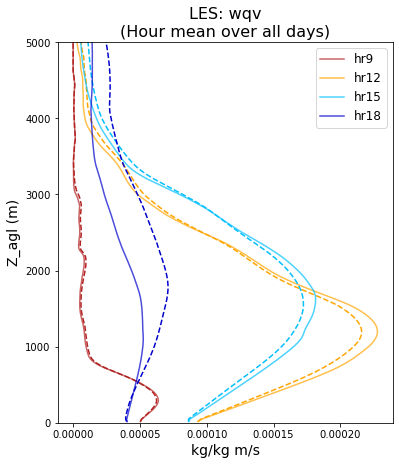

In [47]:
## Choose hours to plot and get mean 

varName = 'wqv'
levName = 'z'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (LES_allDays_allVars_matchDefault["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = LES_allDays_allVars_matchDefault.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title('LES: '+varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('kg/kg m/s', fontsize=14)
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


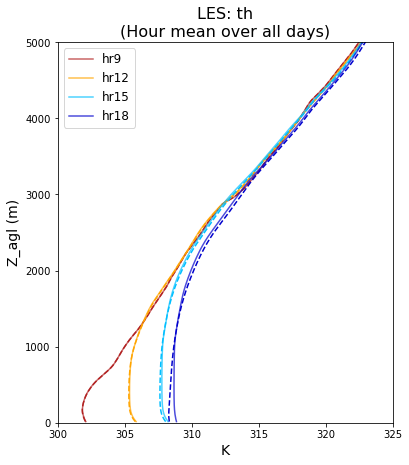

In [48]:
## Choose hours to plot and get mean 

varName = 'th'
levName = 'z'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (LES_allDays_allVars_matchDefault["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = LES_allDays_allVars_matchDefault.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title('LES: '+varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('K', fontsize=14)
    
    axs.set_xlim([300,325])
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


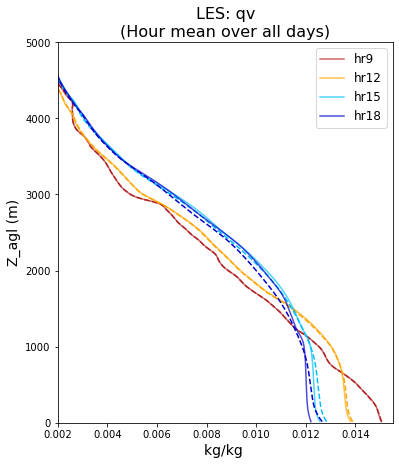

In [49]:
## Choose hours to plot and get mean 

varName = 'qv'
levName = 'z'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (LES_allDays_allVars_matchDefault["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = LES_allDays_allVars_matchDefault.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title('LES: '+varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('kg/kg ', fontsize=14)
    
    axs.set_xlim([0.002,0.0155])
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


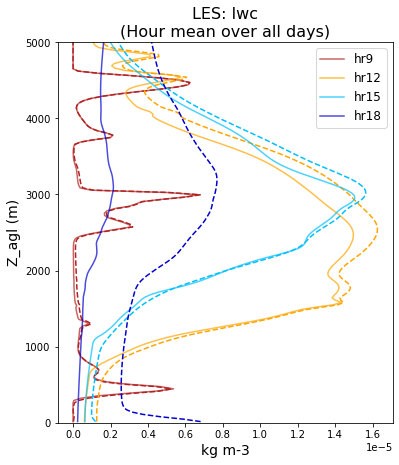

In [65]:
## Choose hours to plot and get mean 

varName = 'lwc'
levName = 'z'
ymin    = 0
ymax    = 5000

hourSel    = [  9,       12,            15,             18]
# colorsList = ['darkorange','limegreen','deepskyblue','darkviolet']
colorsList = ['firebrick','orange','deepskyblue','mediumblue']

fig,axs = plt.subplots(1,1, figsize=(6,7))

for iHr in range(len(hourSel)):
    iTimeSel      = np.where( (LES_allDays_allVars_matchDefault["time.hour"].values==hourSel[iHr]) )[0]
    hourlyMean_DS = LES_allDays_allVars_matchDefault.isel(time=iTimeSel).mean(dim='time')
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG')
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values),alpha=0.7, color=colorsList[iHr], label='hr'+str(hourSel[iHr]) )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), '--',     color=colorsList[iHr], )

    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])

    axs.set_title('LES: '+varName+'\n'+'(Hour mean over all days)', fontsize=16)
    
    axs.set_ylabel('Z_agl (m)', fontsize=14)
    axs.set_xlabel('kg m-3', fontsize=14)
    
    # axs.set_xlim([0.002,0.0155])
    
    # axs.axhline(HMGvar.PBLH.values, linestyle='-.', alpha=0.5, color=colorsList[iHr])
    # axs.axhline(HTGvar.PBLH.values, linestyle=':', alpha=0.5, color=colorsList[iHr])


In [128]:
HMGvar.z.values[100]-HMGvar.z.values[99]

30.24585

In [62]:
LES_allDays_allVars_matchDefault

<xarray.Dataset>
Dimensions:  (case: 2, k: 226, kw: 227, lat: 400, lon: 400, time: 2730)
Coordinates:
  * time     (time) datetime64[ns] 2016-06-10T07:00:00 ... 2017-08-28T22:00:00
  * lat      (lat) float64 36.22 36.22 36.23 36.23 ... 37.11 37.12 37.12 37.12
  * lon      (lon) float64 -98.18 -98.18 -98.17 -98.17 ... -97.07 -97.07 -97.06
  * k        (k) int32 0 1 2 3 4 5 6 7 8 ... 217 218 219 220 221 222 223 224 225
  * kw       (kw) int32 0 1 2 3 4 5 6 7 8 ... 219 220 221 222 223 224 225 226
  * case     (case) object 'HMG' 'HTG'
Data variables:
    lwp      (case, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lwc      (case, time, k) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tke      (case, time) float32 0.0 1.624 6.273 ... 2.687e+03 2.688e+03
    u        (case, time, k) float32 0.0 0.0 0.0 0.0 ... 15.59 16.21 17.05 20.72
    u2       (case, time, k) float32 0.0 0.0 0.0 0.0 ... 0.09612 0.09152 0.07336
    v        (case, time, k) float32 0.0 0.0 0.0 0.0 ... -7.172 -8.844 -9.997
    v2       (case, time, k) float32 0.0 0.0 0.0 0.0 ... 0.04964 0.09668 0.08138
    w        (case, time, kw) float32 0.0 0.0 0.0 ... 9.55e-05 9.801e-05
    w2       (case, time, kw) float32 0.0 0.0 0.0 ... 2.262e-05 4.003e-06
    w3       (case, time, kw) float32 0.0 0.0 0.0 ... 3.315e-08 -1.827e-09
    uw       (case, time, k) float32 0.0 0.0 0.0 ... -0.0003252 -0.0008422
    vw       (case, time, k) float32 0.0 0.0 0.0 ... 0.0004243 0.0002659
    z        (case, time, k) float32 0.0 0.0 0.0 ... 1.447e+04 1.475e+04
    zw       (case, time, kw) float32 0.0 0.0 0.0 ... 1.462e+04 1.488e+04
    qv       (case, time, k) float32 0.0 0.0 0.0 ... 1.014e-06 1.067e-06
    qv2      (case, time, k) float32 0.0 0.0 0.0 ... 1.189e-17 3.862e-18
    th       (case, time, k) float32 0.0 0.0 0.0 0.0 ... 366.4 369.7 373.4 375.3
    th2      (case, time, k) float32 0.0 0.0 0.0 ... 0.03017 0.002622 0.0002428
    thv      (case, time, k) float32 0.0 0.0 0.0 0.0 ... 366.4 369.7 373.4 375.3
    thv2     (case, time, k) float32 0.0 0.0 0.0 ... 0.03017 0.002622 0.0002428
    thl      (case, time, k) float32 0.0 0.0 0.0 0.0 ... 366.4 369.7 373.4 375.3
    thl2     (case, time, k) float32 0.0 0.0 0.0 ... 0.03017 0.002622 0.0002428
    wqv      (case, time, k) float32 0.0 0.0 0.0 ... -2.61e-11 -3.736e-11
    wqt      (case, time, k) float32 0.0 0.0 0.0 ... -2.61e-11 -3.736e-11
    wth      (case, time, k) float32 0.0 0.0 0.0 ... -0.00205 -0.001316
    wthl     (case, time, k) float32 0.0 0.0 0.0 ... -0.00205 -0.001316
    wthv     (case, time, k) float32 0.0 0.0 0.0 ... -0.00205 -0.001316